用不同长度的轨迹训练自编码器

长度：5s

方法：单向重构

---


In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T8PIAE1, Vehicle_Model_Methods
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/data/data5s'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T8PIAE1(torch.tensor(10),torch.tensor(0.25),t_len=50)

# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T8PIAE1(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=98, out_features=2000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=1000, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=48, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=48, bias=True)
    (3): Tanh()
  )
)

In [5]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/logs/log7')


# 4. 训练模型Autoencoder
epochs = 1500

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task7_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.4389529824256897, Val Loss: 0.44959527254104614 


Epoch 2, Train Loss: 0.30823323130607605, Val Loss: 0.24136808514595032 


Epoch 3, Train Loss: 0.2243979573249817, Val Loss: 0.1551498919725418 


Epoch 4, Train Loss: 0.10094518214464188, Val Loss: 0.11300768703222275 


Epoch 5, Train Loss: 0.10318554937839508, Val Loss: 0.09767129272222519 


Epoch 6, Train Loss: 0.1268916130065918, Val Loss: 0.09682957828044891 


Epoch 7, Train Loss: 0.07582788914442062, Val Loss: 0.11815667897462845 


Epoch 8, Train Loss: 0.04607656970620155, Val Loss: 0.07915656268596649 


Epoch 9, Train Loss: 0.11519037932157516, Val Loss: 0.0880342572927475 


Epoch 10, Train Loss: 0.12023115903139114, Val Loss: 0.1510053277015686 


Epoch 11, Train Loss: 0.05628815293312073, Val Loss: 0.07174652814865112 


Epoch 12, Train Loss: 0.23672479391098022, Val Loss: 0.14025792479515076 


Epoch 13, Train Loss: 0.06395214796066284, Val Loss: 0.06522029638290405 


Epoch 14, Train Loss: 0.05341828241944313, Val Loss: 0.06340567022562027 


Epoch 15, Train Loss: 0.11717141419649124, Val Loss: 0.13295817375183105 


Epoch 16, Train Loss: 0.05149424076080322, Val Loss: 0.073204405605793 


Epoch 17, Train Loss: 0.05821319296956062, Val Loss: 0.07260909676551819 


Epoch 18, Train Loss: 0.0958326980471611, Val Loss: 0.197472482919693 


Epoch 19, Train Loss: 0.28653648495674133, Val Loss: 0.11942944675683975 


Epoch 20, Train Loss: 0.05053551495075226, Val Loss: 0.06820423156023026 


Epoch 21, Train Loss: 0.03950870782136917, Val Loss: 0.06617335230112076 


Epoch 22, Train Loss: 0.06223561242222786, Val Loss: 0.0885327160358429 


Epoch 23, Train Loss: 0.04038352891802788, Val Loss: 0.0721292793750763 


Epoch 24, Train Loss: 0.04696296900510788, Val Loss: 0.07316160947084427 


Epoch 25, Train Loss: 0.04287409037351608, Val Loss: 0.08739311993122101 


Epoch 26, Train Loss: 0.03689734265208244, Val Loss: 0.06587280333042145 


Epoch 27, Train Loss: 0.07521365582942963, Val Loss: 0.07515015453100204 


Epoch 28, Train Loss: 0.051100652664899826, Val Loss: 0.04703077673912048 


Epoch 29, Train Loss: 0.03716258704662323, Val Loss: 0.062026359140872955 


Epoch 30, Train Loss: 0.04177265241742134, Val Loss: 0.08196352422237396 


Epoch 31, Train Loss: 0.03474929928779602, Val Loss: 0.06219103932380676 


Epoch 32, Train Loss: 0.15235839784145355, Val Loss: 0.09318909794092178 


Epoch 33, Train Loss: 0.029130300506949425, Val Loss: 0.0594450905919075 


Epoch 34, Train Loss: 0.040559493005275726, Val Loss: 0.06081655994057655 


Epoch 35, Train Loss: 0.027837181463837624, Val Loss: 0.05860903859138489 


Epoch 36, Train Loss: 0.023725377395749092, Val Loss: 0.05221335589885712 


Epoch 37, Train Loss: 0.04943037033081055, Val Loss: 0.07162550836801529 


Epoch 38, Train Loss: 0.03846384957432747, Val Loss: 0.06105460599064827 


Epoch 39, Train Loss: 0.051189832389354706, Val Loss: 0.09274331480264664 


Epoch 40, Train Loss: 0.03263786435127258, Val Loss: 0.049559321254491806 


Epoch 41, Train Loss: 0.05755982920527458, Val Loss: 0.07385258376598358 


Epoch 42, Train Loss: 0.01834476739168167, Val Loss: 0.03739425167441368 


Epoch 43, Train Loss: 0.08885164558887482, Val Loss: 0.049213629215955734 


Epoch 44, Train Loss: 0.059068866074085236, Val Loss: 0.051037829369306564 


Epoch 45, Train Loss: 0.1511041820049286, Val Loss: 0.1698075532913208 


Epoch 46, Train Loss: 0.03745715692639351, Val Loss: 0.048428330570459366 


Epoch 47, Train Loss: 0.046140555292367935, Val Loss: 0.07147140055894852 


Epoch 48, Train Loss: 0.11437972635030746, Val Loss: 0.09172234684228897 


Epoch 49, Train Loss: 0.020541556179523468, Val Loss: 0.04290200024843216 


Epoch 50, Train Loss: 0.020057624205946922, Val Loss: 0.04408499225974083 


Epoch 51, Train Loss: 0.0396345816552639, Val Loss: 0.048929113894701004 


Epoch 52, Train Loss: 0.029767192900180817, Val Loss: 0.04953363537788391 


Epoch 53, Train Loss: 0.03630880266427994, Val Loss: 0.05735515430569649 


Epoch 54, Train Loss: 0.03533594310283661, Val Loss: 0.09722990542650223 


Epoch 55, Train Loss: 0.03785431757569313, Val Loss: 0.040956851094961166 


Epoch 56, Train Loss: 0.08131177723407745, Val Loss: 0.06710858643054962 


Epoch 57, Train Loss: 0.01873614825308323, Val Loss: 0.05603119730949402 


Epoch 58, Train Loss: 0.022842036560177803, Val Loss: 0.03986430540680885 


Epoch 59, Train Loss: 0.031516145914793015, Val Loss: 0.05637530982494354 


Epoch 60, Train Loss: 0.027338026091456413, Val Loss: 0.0460171215236187 


Epoch 61, Train Loss: 0.04284478724002838, Val Loss: 0.049626000225543976 


Epoch 62, Train Loss: 0.0920134112238884, Val Loss: 0.1308116614818573 


Epoch 63, Train Loss: 0.030367765575647354, Val Loss: 0.04701753705739975 


Epoch 64, Train Loss: 0.06623846292495728, Val Loss: 0.06298484653234482 


Epoch 65, Train Loss: 0.022069493308663368, Val Loss: 0.06332996487617493 


Epoch 66, Train Loss: 0.04345765337347984, Val Loss: 0.054348740726709366 


Epoch 67, Train Loss: 0.02134266309440136, Val Loss: 0.04525136947631836 


Epoch 68, Train Loss: 0.04125293344259262, Val Loss: 0.05327008664608002 


Epoch 69, Train Loss: 0.031883321702480316, Val Loss: 0.0393577478826046 


Epoch 70, Train Loss: 0.04227904975414276, Val Loss: 0.04790543392300606 


Epoch 71, Train Loss: 0.13779021799564362, Val Loss: 0.07244119793176651 


Epoch 72, Train Loss: 0.0191040001809597, Val Loss: 0.04184051230549812 


Epoch 73, Train Loss: 0.016628727316856384, Val Loss: 0.042423248291015625 


Epoch 74, Train Loss: 0.023781808093190193, Val Loss: 0.04623349756002426 


Epoch 75, Train Loss: 0.04323155805468559, Val Loss: 0.03557216748595238 


Epoch 76, Train Loss: 0.020610269159078598, Val Loss: 0.03135973587632179 


Epoch 77, Train Loss: 0.028762195259332657, Val Loss: 0.04174564778804779 


Epoch 78, Train Loss: 0.009331612847745419, Val Loss: 0.03486353158950806 


Epoch 79, Train Loss: 0.04420418292284012, Val Loss: 0.06516142934560776 


Epoch 80, Train Loss: 0.01664704643189907, Val Loss: 0.041862230747938156 


Epoch 81, Train Loss: 0.06670704483985901, Val Loss: 0.09805068373680115 


Epoch 82, Train Loss: 0.03837694972753525, Val Loss: 0.04460041597485542 


Epoch 83, Train Loss: 0.05880815163254738, Val Loss: 0.043606434017419815 


Epoch 84, Train Loss: 0.02034413255751133, Val Loss: 0.040932100266218185 


Epoch 85, Train Loss: 0.04138164594769478, Val Loss: 0.04642201587557793 


Epoch 86, Train Loss: 0.037130653858184814, Val Loss: 0.04019986465573311 


Epoch 87, Train Loss: 0.02359865792095661, Val Loss: 0.03031589649617672 


Epoch 88, Train Loss: 0.01216419879347086, Val Loss: 0.04419100657105446 


Epoch 89, Train Loss: 0.01546737365424633, Val Loss: 0.03203753009438515 


Epoch 90, Train Loss: 0.04830663651227951, Val Loss: 0.03359108790755272 


Epoch 91, Train Loss: 0.020297905430197716, Val Loss: 0.03818691149353981 


Epoch 92, Train Loss: 0.03963526338338852, Val Loss: 0.061246711760759354 


Epoch 93, Train Loss: 0.011750781908631325, Val Loss: 0.03365316241979599 


Epoch 94, Train Loss: 0.011393105611205101, Val Loss: 0.0362936295568943 


Epoch 95, Train Loss: 0.010649661533534527, Val Loss: 0.028290854766964912 


Epoch 96, Train Loss: 0.02167634665966034, Val Loss: 0.03096807561814785 


Epoch 97, Train Loss: 0.018739497289061546, Val Loss: 0.033208172768354416 


Epoch 98, Train Loss: 0.029309123754501343, Val Loss: 0.05049430578947067 


Epoch 99, Train Loss: 0.019587747752666473, Val Loss: 0.041277553886175156 


Epoch 100, Train Loss: 0.03363664448261261, Val Loss: 0.042403530329465866 


Epoch 101, Train Loss: 0.01958211325109005, Val Loss: 0.04736218601465225 


Epoch 102, Train Loss: 0.015940019860863686, Val Loss: 0.0405375212430954 


Epoch 103, Train Loss: 0.04247628524899483, Val Loss: 0.041248198598623276 


Epoch 104, Train Loss: 0.0603548064827919, Val Loss: 0.030914273113012314 


Epoch 105, Train Loss: 0.009755331091582775, Val Loss: 0.02883562259376049 


Epoch 106, Train Loss: 0.035932913422584534, Val Loss: 0.04043826833367348 


Epoch 107, Train Loss: 0.011893194168806076, Val Loss: 0.03264514356851578 


Epoch 108, Train Loss: 0.021453050896525383, Val Loss: 0.03525553271174431 


Epoch 109, Train Loss: 0.013539856299757957, Val Loss: 0.03104383498430252 


Epoch 110, Train Loss: 0.015547141432762146, Val Loss: 0.030242275446653366 


Epoch 111, Train Loss: 0.11291828751564026, Val Loss: 0.062091078609228134 


Epoch 112, Train Loss: 0.035908471792936325, Val Loss: 0.04962427169084549 


Epoch 113, Train Loss: 0.012296007014811039, Val Loss: 0.03146929666399956 


Epoch 114, Train Loss: 0.012380002066493034, Val Loss: 0.03109903447329998 


Epoch 115, Train Loss: 0.011460987851023674, Val Loss: 0.0359535738825798 


Epoch 116, Train Loss: 0.019783683121204376, Val Loss: 0.03683239221572876 


Epoch 117, Train Loss: 0.010707800276577473, Val Loss: 0.031511519104242325 


Epoch 118, Train Loss: 0.0466056652367115, Val Loss: 0.08180761337280273 


Epoch 119, Train Loss: 0.014179684221744537, Val Loss: 0.04329800605773926 


Epoch 120, Train Loss: 0.0247965045273304, Val Loss: 0.04042866826057434 


Epoch 121, Train Loss: 0.03571723774075508, Val Loss: 0.05510793626308441 


Epoch 122, Train Loss: 0.012639407999813557, Val Loss: 0.03404447063803673 


Epoch 123, Train Loss: 0.014842803589999676, Val Loss: 0.029590671882033348 


Epoch 124, Train Loss: 0.0115330396220088, Val Loss: 0.026273734867572784 


Epoch 125, Train Loss: 0.08084463328123093, Val Loss: 0.027475345879793167 


Epoch 126, Train Loss: 0.015979338437318802, Val Loss: 0.037891726940870285 


Epoch 127, Train Loss: 0.011696134693920612, Val Loss: 0.033616553992033005 


Epoch 128, Train Loss: 0.012641394510865211, Val Loss: 0.03382284566760063 


Epoch 129, Train Loss: 0.017914937809109688, Val Loss: 0.03641477972269058 


Epoch 130, Train Loss: 0.01835920475423336, Val Loss: 0.03748249635100365 


Epoch 131, Train Loss: 0.038696564733982086, Val Loss: 0.04863004386425018 


Epoch 132, Train Loss: 0.014840873889625072, Val Loss: 0.03904139623045921 


Epoch 133, Train Loss: 0.008283489383757114, Val Loss: 0.031526800245046616 


Epoch 134, Train Loss: 0.02374165505170822, Val Loss: 0.03794806823134422 


Epoch 135, Train Loss: 0.05360853299498558, Val Loss: 0.03183789551258087 


Epoch 136, Train Loss: 0.016717897728085518, Val Loss: 0.02807682752609253 


Epoch 137, Train Loss: 0.01073884405195713, Val Loss: 0.02967473305761814 


Epoch 138, Train Loss: 0.03491995856165886, Val Loss: 0.04215475544333458 


Epoch 139, Train Loss: 0.02755598910152912, Val Loss: 0.03442970663309097 


Epoch 140, Train Loss: 0.01911071501672268, Val Loss: 0.03159848600625992 


Epoch 141, Train Loss: 0.011750321835279465, Val Loss: 0.032451074570417404 


Epoch 142, Train Loss: 0.42291074991226196, Val Loss: 0.2767266631126404 


Epoch 143, Train Loss: 0.0091041699051857, Val Loss: 0.026336396113038063 


Epoch 144, Train Loss: 0.019453812390565872, Val Loss: 0.034337859600782394 


Epoch 145, Train Loss: 0.012089776806533337, Val Loss: 0.02900376357138157 


Epoch 146, Train Loss: 0.04783613607287407, Val Loss: 0.06775595247745514 


Epoch 147, Train Loss: 0.014672640711069107, Val Loss: 0.027974367141723633 


Epoch 148, Train Loss: 0.020910579711198807, Val Loss: 0.03430932015180588 


Epoch 149, Train Loss: 0.024738000705838203, Val Loss: 0.03273255378007889 


Epoch 150, Train Loss: 0.014119583182036877, Val Loss: 0.0293788630515337 


Epoch 151, Train Loss: 0.012795361690223217, Val Loss: 0.0307677760720253 


Epoch 152, Train Loss: 0.010668010450899601, Val Loss: 0.02746926248073578 


Epoch 153, Train Loss: 0.013101551681756973, Val Loss: 0.025912461802363396 


Epoch 154, Train Loss: 0.015604215674102306, Val Loss: 0.03383913263678551 


Epoch 155, Train Loss: 0.03674881532788277, Val Loss: 0.03277966380119324 


Epoch 156, Train Loss: 0.017256367951631546, Val Loss: 0.04176183417439461 


Epoch 157, Train Loss: 0.013528496026992798, Val Loss: 0.02855508215725422 


Epoch 158, Train Loss: 0.012722591869533062, Val Loss: 0.03158527612686157 


Epoch 159, Train Loss: 0.03732239454984665, Val Loss: 0.03533872589468956 


Epoch 160, Train Loss: 0.011065669357776642, Val Loss: 0.028339214622974396 


Epoch 161, Train Loss: 0.02092224545776844, Val Loss: 0.02744673378765583 


Epoch 162, Train Loss: 0.027020739391446114, Val Loss: 0.025322269648313522 


Epoch 163, Train Loss: 0.01104664709419012, Val Loss: 0.03373945504426956 


Epoch 164, Train Loss: 0.032065168023109436, Val Loss: 0.046449076384305954 


Epoch 165, Train Loss: 0.01662152260541916, Val Loss: 0.03269856795668602 


Epoch 166, Train Loss: 0.010919036343693733, Val Loss: 0.02766520343720913 


Epoch 167, Train Loss: 0.0111036142334342, Val Loss: 0.02613065019249916 


Epoch 168, Train Loss: 0.02154134400188923, Val Loss: 0.03076976351439953 


Epoch 169, Train Loss: 0.04927486181259155, Val Loss: 0.07556529343128204 


Epoch 170, Train Loss: 0.009712673723697662, Val Loss: 0.025989225134253502 


Epoch 171, Train Loss: 0.015450021252036095, Val Loss: 0.02523641847074032 


Epoch 172, Train Loss: 0.012938694097101688, Val Loss: 0.03606110066175461 


Epoch 173, Train Loss: 0.019381625577807426, Val Loss: 0.034357793629169464 


Epoch 174, Train Loss: 0.01769791543483734, Val Loss: 0.03700821101665497 


Epoch 175, Train Loss: 0.01042252779006958, Val Loss: 0.02801170013844967 


Epoch 176, Train Loss: 0.008801652118563652, Val Loss: 0.026167694479227066 


Epoch 177, Train Loss: 0.0216229110956192, Val Loss: 0.027593741193413734 


Epoch 178, Train Loss: 0.030115650966763496, Val Loss: 0.03893386200070381 


Epoch 179, Train Loss: 0.015066172927618027, Val Loss: 0.025637438520789146 


Epoch 180, Train Loss: 0.01367220003157854, Val Loss: 0.032120537012815475 


Epoch 181, Train Loss: 0.023211346939206123, Val Loss: 0.035922758281230927 


Epoch 182, Train Loss: 0.022179506719112396, Val Loss: 0.025415075942873955 


Epoch 183, Train Loss: 0.012654769234359264, Val Loss: 0.022704370319843292 


Epoch 184, Train Loss: 0.020762033760547638, Val Loss: 0.024594483897089958 


Epoch 185, Train Loss: 0.009416664950549603, Val Loss: 0.024976547807455063 


Epoch 186, Train Loss: 0.032713234424591064, Val Loss: 0.025409599766135216 


Epoch 187, Train Loss: 0.018857114017009735, Val Loss: 0.03130721300840378 


Epoch 188, Train Loss: 0.010106588713824749, Val Loss: 0.02645104005932808 


Epoch 189, Train Loss: 0.0055410913191735744, Val Loss: 0.022698041051626205 


Epoch 190, Train Loss: 0.007050506304949522, Val Loss: 0.026169300079345703 


Epoch 191, Train Loss: 0.010256154462695122, Val Loss: 0.03178019821643829 


Epoch 192, Train Loss: 0.006939303129911423, Val Loss: 0.022444138303399086 


Epoch 193, Train Loss: 0.01249898411333561, Val Loss: 0.029094019904732704 


Epoch 194, Train Loss: 0.007853426039218903, Val Loss: 0.024922208860516548 


Epoch 195, Train Loss: 0.02359268255531788, Val Loss: 0.04862980544567108 


Epoch 196, Train Loss: 0.007460893597453833, Val Loss: 0.0328117311000824 


Epoch 197, Train Loss: 0.013145986013114452, Val Loss: 0.023914137855172157 


Epoch 198, Train Loss: 0.008048542775213718, Val Loss: 0.024075765162706375 


Epoch 199, Train Loss: 0.026455743238329887, Val Loss: 0.029494758695364 


Epoch 200, Train Loss: 0.010025684721767902, Val Loss: 0.027435919269919395 


Epoch 201, Train Loss: 0.014469312503933907, Val Loss: 0.027303295210003853 


Epoch 202, Train Loss: 0.0121400635689497, Val Loss: 0.025707777589559555 


Epoch 203, Train Loss: 0.012685643509030342, Val Loss: 0.031829673796892166 


Epoch 204, Train Loss: 0.01279383897781372, Val Loss: 0.02714378573000431 


Epoch 205, Train Loss: 0.011262170039117336, Val Loss: 0.02814152091741562 


Epoch 206, Train Loss: 0.011047541163861752, Val Loss: 0.03196275979280472 


Epoch 207, Train Loss: 0.029250618070364, Val Loss: 0.042042944580316544 


Epoch 208, Train Loss: 0.012660449370741844, Val Loss: 0.02308230847120285 


Epoch 209, Train Loss: 0.011023328639566898, Val Loss: 0.034162476658821106 


Epoch 210, Train Loss: 0.02009088546037674, Val Loss: 0.030530136078596115 


Epoch 211, Train Loss: 0.007659435272216797, Val Loss: 0.04191138222813606 


Epoch 212, Train Loss: 0.02463976852595806, Val Loss: 0.03726458549499512 


Epoch 213, Train Loss: 0.010633459314703941, Val Loss: 0.03305952250957489 


Epoch 214, Train Loss: 0.006454129237681627, Val Loss: 0.024950869381427765 


Epoch 215, Train Loss: 0.008259736001491547, Val Loss: 0.02854851260781288 


Epoch 216, Train Loss: 0.013669281266629696, Val Loss: 0.0284194927662611 


Epoch 217, Train Loss: 0.007819772697985172, Val Loss: 0.02468232251703739 


Epoch 218, Train Loss: 0.013093849644064903, Val Loss: 0.027929550036787987 


Epoch 219, Train Loss: 0.01237996481359005, Val Loss: 0.024590060114860535 


Epoch 220, Train Loss: 0.009566214866936207, Val Loss: 0.02199964039027691 


Epoch 221, Train Loss: 0.03643440827727318, Val Loss: 0.05031751096248627 


Epoch 222, Train Loss: 0.012049110606312752, Val Loss: 0.03132076561450958 


Epoch 223, Train Loss: 0.025551097467541695, Val Loss: 0.041308484971523285 


Epoch 224, Train Loss: 0.01715184934437275, Val Loss: 0.031615715473890305 


Epoch 225, Train Loss: 0.01743772253394127, Val Loss: 0.03453968092799187 


Epoch 226, Train Loss: 0.013389465399086475, Val Loss: 0.030272239819169044 


Epoch 227, Train Loss: 0.045809049159288406, Val Loss: 0.07427726686000824 


Epoch 228, Train Loss: 0.028918353840708733, Val Loss: 0.030513951554894447 


Epoch 229, Train Loss: 0.011181886307895184, Val Loss: 0.031865768134593964 


Epoch 230, Train Loss: 0.011070139706134796, Val Loss: 0.02716408669948578 


Epoch 231, Train Loss: 0.009345628321170807, Val Loss: 0.02536671608686447 


Epoch 232, Train Loss: 0.03407115116715431, Val Loss: 0.05150412395596504 


Epoch 233, Train Loss: 0.012952407822012901, Val Loss: 0.03090365044772625 


Epoch 234, Train Loss: 0.012241664342582226, Val Loss: 0.027298029512166977 


Epoch 235, Train Loss: 0.007556937634944916, Val Loss: 0.02561844140291214 


Epoch 236, Train Loss: 0.012102414853870869, Val Loss: 0.027278998866677284 


Epoch 237, Train Loss: 0.011093026027083397, Val Loss: 0.0315513052046299 


Epoch 238, Train Loss: 0.07625226676464081, Val Loss: 0.10248728096485138 


Epoch 239, Train Loss: 0.010941848158836365, Val Loss: 0.02621215581893921 


Epoch 240, Train Loss: 0.006522538140416145, Val Loss: 0.0257234089076519 


Epoch 241, Train Loss: 0.03298885002732277, Val Loss: 0.03462997078895569 


Epoch 242, Train Loss: 0.022193193435668945, Val Loss: 0.0371810644865036 


Epoch 243, Train Loss: 0.007760764565318823, Val Loss: 0.02222076617181301 


Epoch 244, Train Loss: 0.00769102293998003, Val Loss: 0.024778055027127266 


Epoch 245, Train Loss: 0.010070006363093853, Val Loss: 0.022854087874293327 


Epoch 246, Train Loss: 0.010729855857789516, Val Loss: 0.020829660817980766 


Epoch 247, Train Loss: 0.012195242568850517, Val Loss: 0.026026412844657898 


Epoch 248, Train Loss: 0.04186100512742996, Val Loss: 0.044136300683021545 


Epoch 249, Train Loss: 0.014438997954130173, Val Loss: 0.030186083167791367 


Epoch 250, Train Loss: 0.009037251584231853, Val Loss: 0.02122960425913334 


Epoch 251, Train Loss: 0.015299117192626, Val Loss: 0.026241282001137733 


Epoch 252, Train Loss: 0.011314354836940765, Val Loss: 0.025478795170783997 


Epoch 253, Train Loss: 0.01744188368320465, Val Loss: 0.03682287409901619 


Epoch 254, Train Loss: 0.011952833272516727, Val Loss: 0.02324707992374897 


Epoch 255, Train Loss: 0.009504320099949837, Val Loss: 0.021165072917938232 


Epoch 256, Train Loss: 0.019396841526031494, Val Loss: 0.029046418145298958 


Epoch 257, Train Loss: 0.007993330247700214, Val Loss: 0.024325044825673103 


Epoch 258, Train Loss: 0.01199400145560503, Val Loss: 0.028624748811125755 


Epoch 259, Train Loss: 0.02781226672232151, Val Loss: 0.028021251782774925 


Epoch 260, Train Loss: 0.013457468710839748, Val Loss: 0.025715485215187073 


Epoch 261, Train Loss: 0.029734136536717415, Val Loss: 0.030900584533810616 


Epoch 262, Train Loss: 0.008370570838451385, Val Loss: 0.021753616631031036 


Epoch 263, Train Loss: 0.01370670273900032, Val Loss: 0.02519579418003559 


Epoch 264, Train Loss: 0.012513390742242336, Val Loss: 0.026459285989403725 


Epoch 265, Train Loss: 0.01611071452498436, Val Loss: 0.044666361063718796 


Epoch 266, Train Loss: 0.017655741423368454, Val Loss: 0.03265771642327309 


Epoch 267, Train Loss: 0.01566006988286972, Val Loss: 0.03020869567990303 


Epoch 268, Train Loss: 0.009374718181788921, Val Loss: 0.027735546231269836 


Epoch 269, Train Loss: 0.018172644078731537, Val Loss: 0.02694486640393734 


Epoch 270, Train Loss: 0.010983160696923733, Val Loss: 0.022824900224804878 


Epoch 271, Train Loss: 0.013627776876091957, Val Loss: 0.03394366055727005 


Epoch 272, Train Loss: 0.0076679945923388, Val Loss: 0.02444557286798954 


Epoch 273, Train Loss: 0.007921840995550156, Val Loss: 0.033186376094818115 


Epoch 274, Train Loss: 0.015998320654034615, Val Loss: 0.02545909583568573 


Epoch 275, Train Loss: 0.010585363954305649, Val Loss: 0.029602212831377983 


Epoch 276, Train Loss: 0.008484282530844212, Val Loss: 0.021456418558955193 


Epoch 277, Train Loss: 0.00966960471123457, Val Loss: 0.024436336010694504 


Epoch 278, Train Loss: 0.012000875547528267, Val Loss: 0.023471709340810776 


Epoch 279, Train Loss: 0.015989650040864944, Val Loss: 0.03665609285235405 


Epoch 280, Train Loss: 0.011758693493902683, Val Loss: 0.03016442246735096 


Epoch 281, Train Loss: 0.00796982366591692, Val Loss: 0.026835940778255463 


Epoch 282, Train Loss: 0.015355482697486877, Val Loss: 0.02833963744342327 


Epoch 283, Train Loss: 0.006653384305536747, Val Loss: 0.02678334154188633 


Epoch 284, Train Loss: 0.006671938579529524, Val Loss: 0.022818973287940025 


Epoch 285, Train Loss: 0.01110131572932005, Val Loss: 0.02820754423737526 


Epoch 286, Train Loss: 0.0068044718354940414, Val Loss: 0.026201657950878143 


Epoch 287, Train Loss: 0.012318417429924011, Val Loss: 0.0307743102312088 


Epoch 288, Train Loss: 0.010145938955247402, Val Loss: 0.032222624868154526 


Epoch 289, Train Loss: 0.007930170744657516, Val Loss: 0.027309196069836617 


Epoch 290, Train Loss: 0.015498855151236057, Val Loss: 0.03185940533876419 


Epoch 291, Train Loss: 0.017965417355298996, Val Loss: 0.034284669905900955 


Epoch 292, Train Loss: 0.00882856547832489, Val Loss: 0.025882722809910774 


Epoch 293, Train Loss: 0.007728784345090389, Val Loss: 0.02291472814977169 


Epoch 294, Train Loss: 0.015547319315373898, Val Loss: 0.021152853965759277 


Epoch 295, Train Loss: 0.01643926464021206, Val Loss: 0.022406894713640213 


Epoch 296, Train Loss: 0.013666583225131035, Val Loss: 0.023769255727529526 


Epoch 297, Train Loss: 0.011658867821097374, Val Loss: 0.026572110131382942 


Epoch 298, Train Loss: 0.006466738414019346, Val Loss: 0.021672535687685013 


Epoch 299, Train Loss: 0.01659821905195713, Val Loss: 0.03349441662430763 


Epoch 300, Train Loss: 0.011735684238374233, Val Loss: 0.026834888383746147 


Epoch 301, Train Loss: 0.009237664751708508, Val Loss: 0.03383738175034523 


Epoch 302, Train Loss: 0.009307037107646465, Val Loss: 0.026656759902834892 


Epoch 303, Train Loss: 0.01226651668548584, Val Loss: 0.039331573992967606 


Epoch 304, Train Loss: 0.009891296736896038, Val Loss: 0.022557884454727173 


Epoch 305, Train Loss: 0.013009141199290752, Val Loss: 0.02292497269809246 


Epoch 306, Train Loss: 0.007370570674538612, Val Loss: 0.026028482243418694 


Epoch 307, Train Loss: 0.025067610666155815, Val Loss: 0.02484026737511158 


Epoch 308, Train Loss: 0.026734942570328712, Val Loss: 0.031039142981171608 


Epoch 309, Train Loss: 0.018672537058591843, Val Loss: 0.025861075147986412 


Epoch 310, Train Loss: 0.01094293687492609, Val Loss: 0.025466596707701683 


Epoch 311, Train Loss: 0.009849661961197853, Val Loss: 0.02353064902126789 


Epoch 312, Train Loss: 0.012245949357748032, Val Loss: 0.032151106745004654 


Epoch 313, Train Loss: 0.04660584777593613, Val Loss: 0.05394218489527702 


Epoch 314, Train Loss: 0.006973474286496639, Val Loss: 0.02593167871236801 


Epoch 315, Train Loss: 0.010783388279378414, Val Loss: 0.02112661860883236 


Epoch 316, Train Loss: 0.00901215709745884, Val Loss: 0.029923854395747185 


Epoch 317, Train Loss: 0.027170056477189064, Val Loss: 0.03911592438817024 


Epoch 318, Train Loss: 0.008716374635696411, Val Loss: 0.027156533673405647 


Epoch 319, Train Loss: 0.021615440025925636, Val Loss: 0.03931373357772827 


Epoch 320, Train Loss: 0.010832817293703556, Val Loss: 0.02291760966181755 


Epoch 321, Train Loss: 0.017227666452527046, Val Loss: 0.02719110995531082 


Epoch 322, Train Loss: 0.020253151655197144, Val Loss: 0.021397704258561134 


Epoch 323, Train Loss: 0.005611516535282135, Val Loss: 0.02085699513554573 


Epoch 324, Train Loss: 0.008646506816148758, Val Loss: 0.026258980855345726 


Epoch 325, Train Loss: 0.008533820509910583, Val Loss: 0.025372494012117386 


Epoch 326, Train Loss: 0.006159571465104818, Val Loss: 0.02519516833126545 


Epoch 327, Train Loss: 0.008822358213365078, Val Loss: 0.02368936501443386 


Epoch 328, Train Loss: 0.01400907151401043, Val Loss: 0.026257069781422615 


Epoch 329, Train Loss: 0.01011277548968792, Val Loss: 0.027892643585801125 


Epoch 330, Train Loss: 0.016228042542934418, Val Loss: 0.03736981749534607 


Epoch 331, Train Loss: 0.007211313582956791, Val Loss: 0.0257869940251112 


Epoch 332, Train Loss: 0.0074427309446036816, Val Loss: 0.02955280989408493 


Epoch 333, Train Loss: 0.017483161762356758, Val Loss: 0.029796991497278214 


Epoch 334, Train Loss: 0.017448844388127327, Val Loss: 0.028077507391572 


Epoch 335, Train Loss: 0.013959331437945366, Val Loss: 0.03859282657504082 


Epoch 336, Train Loss: 0.010495304130017757, Val Loss: 0.033117663115262985 


Epoch 337, Train Loss: 0.009976586326956749, Val Loss: 0.024618159979581833 


Epoch 338, Train Loss: 0.026789410039782524, Val Loss: 0.026024842634797096 


Epoch 339, Train Loss: 0.013572074472904205, Val Loss: 0.029332999140024185 


Epoch 340, Train Loss: 0.011518566869199276, Val Loss: 0.02718215622007847 


Epoch 341, Train Loss: 0.007169048301875591, Val Loss: 0.029687894508242607 


Epoch 342, Train Loss: 0.0065636178478598595, Val Loss: 0.02339511178433895 


Epoch 343, Train Loss: 0.012831902131438255, Val Loss: 0.024026213213801384 


Epoch 344, Train Loss: 0.014543335884809494, Val Loss: 0.02344938926398754 


Epoch 345, Train Loss: 0.016613297164440155, Val Loss: 0.027365585789084435 


Epoch 346, Train Loss: 0.016162525862455368, Val Loss: 0.030156752094626427 


Epoch 347, Train Loss: 0.012505175545811653, Val Loss: 0.031044496223330498 


Epoch 348, Train Loss: 0.011543897911906242, Val Loss: 0.027388539165258408 


Epoch 349, Train Loss: 0.011204319074749947, Val Loss: 0.027728140354156494 


Epoch 350, Train Loss: 0.02022634632885456, Val Loss: 0.02342497557401657 


Epoch 351, Train Loss: 0.016766859218478203, Val Loss: 0.03077409602701664 


Epoch 352, Train Loss: 0.013546927832067013, Val Loss: 0.02703467570245266 


Epoch 353, Train Loss: 0.01995217241346836, Val Loss: 0.02248990722000599 


Epoch 354, Train Loss: 0.007451705634593964, Val Loss: 0.02284402959048748 


Epoch 355, Train Loss: 0.06675514578819275, Val Loss: 0.023187970742583275 


Epoch 356, Train Loss: 0.013164344243705273, Val Loss: 0.018802430480718613 


Epoch 357, Train Loss: 0.011836595833301544, Val Loss: 0.02691606618463993 


Epoch 358, Train Loss: 0.005884124897420406, Val Loss: 0.02585730142891407 


Epoch 359, Train Loss: 0.02315225824713707, Val Loss: 0.03225855529308319 


Epoch 360, Train Loss: 0.03071596659719944, Val Loss: 0.03721834346652031 


Epoch 361, Train Loss: 0.011837936006486416, Val Loss: 0.024503549560904503 


Epoch 362, Train Loss: 0.009475493803620338, Val Loss: 0.029754139482975006 


Epoch 363, Train Loss: 0.009079714305698872, Val Loss: 0.027732152491807938 


Epoch 364, Train Loss: 0.016528945416212082, Val Loss: 0.028648026287555695 


Epoch 365, Train Loss: 0.011888435110449791, Val Loss: 0.02816605567932129 


Epoch 366, Train Loss: 0.032673031091690063, Val Loss: 0.06601692736148834 


Epoch 367, Train Loss: 0.008309279568493366, Val Loss: 0.02630622684955597 


Epoch 368, Train Loss: 0.015738731250166893, Val Loss: 0.026218563318252563 


Epoch 369, Train Loss: 0.007463515270501375, Val Loss: 0.028480475768446922 


Epoch 370, Train Loss: 0.00764420023187995, Val Loss: 0.024335360154509544 


Epoch 371, Train Loss: 0.010276438668370247, Val Loss: 0.03081406280398369 


Epoch 372, Train Loss: 0.02417125180363655, Val Loss: 0.029227161779999733 


Epoch 373, Train Loss: 0.006584887392818928, Val Loss: 0.025534966960549355 


Epoch 374, Train Loss: 0.009717106819152832, Val Loss: 0.02461937814950943 


Epoch 375, Train Loss: 0.007871522568166256, Val Loss: 0.021673358976840973 


Epoch 376, Train Loss: 0.017553243786096573, Val Loss: 0.02358797937631607 


Epoch 377, Train Loss: 0.008828856982290745, Val Loss: 0.02732446976006031 


Epoch 378, Train Loss: 0.01757821999490261, Val Loss: 0.025058865547180176 


Epoch 379, Train Loss: 0.012174751609563828, Val Loss: 0.029162263497710228 


Epoch 380, Train Loss: 0.0156256016343832, Val Loss: 0.0321049690246582 


Epoch 381, Train Loss: 0.011423718184232712, Val Loss: 0.029434386640787125 


Epoch 382, Train Loss: 0.0065838005393743515, Val Loss: 0.02152235433459282 


Epoch 383, Train Loss: 0.01112667191773653, Val Loss: 0.027480287477374077 


Epoch 384, Train Loss: 0.009933659806847572, Val Loss: 0.02157382294535637 


Epoch 385, Train Loss: 0.007115303538739681, Val Loss: 0.022276263684034348 


Epoch 386, Train Loss: 0.0209184717386961, Val Loss: 0.03484977409243584 


Epoch 387, Train Loss: 0.021855736151337624, Val Loss: 0.04495878517627716 


Epoch 388, Train Loss: 0.015640083700418472, Val Loss: 0.03415905311703682 


Epoch 389, Train Loss: 0.01622927188873291, Val Loss: 0.02446170523762703 


Epoch 390, Train Loss: 0.006368397269397974, Val Loss: 0.023128246888518333 


Epoch 391, Train Loss: 0.01693696901202202, Val Loss: 0.02681807614862919 


Epoch 392, Train Loss: 0.024437256157398224, Val Loss: 0.04340752959251404 


Epoch 393, Train Loss: 0.007353577762842178, Val Loss: 0.02283482812345028 


Epoch 394, Train Loss: 0.013932004570960999, Val Loss: 0.02921871840953827 


Epoch 395, Train Loss: 0.008321304805576801, Val Loss: 0.02769453451037407 


Epoch 396, Train Loss: 0.024412933737039566, Val Loss: 0.040424272418022156 


Epoch 397, Train Loss: 0.017543505877256393, Val Loss: 0.04046729952096939 


Epoch 398, Train Loss: 0.03306667134165764, Val Loss: 0.0354442335665226 


Epoch 399, Train Loss: 0.0231024157255888, Val Loss: 0.032130997627973557 


Epoch 400, Train Loss: 0.007657879963517189, Val Loss: 0.028652116656303406 


Epoch 401, Train Loss: 0.01443455833941698, Val Loss: 0.02243858017027378 


Epoch 402, Train Loss: 0.011144053190946579, Val Loss: 0.02348880097270012 


Epoch 403, Train Loss: 0.008193377405405045, Val Loss: 0.022839879617094994 


Epoch 404, Train Loss: 0.019344454631209373, Val Loss: 0.032364241778850555 


Epoch 405, Train Loss: 0.019048184156417847, Val Loss: 0.03705257922410965 


Epoch 406, Train Loss: 0.01118567492812872, Val Loss: 0.02977290004491806 


Epoch 407, Train Loss: 0.0060951546765863895, Val Loss: 0.0265815369784832 


Epoch 408, Train Loss: 0.018096262589097023, Val Loss: 0.028761286288499832 


Epoch 409, Train Loss: 0.007421907968819141, Val Loss: 0.02715136483311653 


Epoch 410, Train Loss: 0.008312029764056206, Val Loss: 0.033772289752960205 


Epoch 411, Train Loss: 0.008448828011751175, Val Loss: 0.028692731633782387 


Epoch 412, Train Loss: 0.009923473000526428, Val Loss: 0.03228387609124184 


Epoch 413, Train Loss: 0.005262545309960842, Val Loss: 0.02274199388921261 


Epoch 414, Train Loss: 0.004885854199528694, Val Loss: 0.023974483832716942 


Epoch 415, Train Loss: 0.015702582895755768, Val Loss: 0.024127108976244926 


Epoch 416, Train Loss: 0.013900971971452236, Val Loss: 0.040131825953722 


Epoch 417, Train Loss: 0.005415448918938637, Val Loss: 0.023571088910102844 


Epoch 418, Train Loss: 0.005617267917841673, Val Loss: 0.026535147801041603 


Epoch 419, Train Loss: 0.02006388269364834, Val Loss: 0.032488878816366196 


Epoch 420, Train Loss: 0.014529234729707241, Val Loss: 0.027345221489667892 


Epoch 421, Train Loss: 0.011623182334005833, Val Loss: 0.027508292347192764 


Epoch 422, Train Loss: 0.007642893586307764, Val Loss: 0.02526136115193367 


Epoch 423, Train Loss: 0.012632079422473907, Val Loss: 0.02759397029876709 


Epoch 424, Train Loss: 0.038474276661872864, Val Loss: 0.028830571100115776 


Epoch 425, Train Loss: 0.009510914795100689, Val Loss: 0.025620268657803535 


Epoch 426, Train Loss: 0.01813003607094288, Val Loss: 0.02569062076508999 


Epoch 427, Train Loss: 0.0093398941680789, Val Loss: 0.02446257695555687 


Epoch 428, Train Loss: 0.009998807683587074, Val Loss: 0.03481203690171242 


Epoch 429, Train Loss: 0.006903777364641428, Val Loss: 0.03189007192850113 


Epoch 430, Train Loss: 0.09699443727731705, Val Loss: 0.0350671261548996 


Epoch 431, Train Loss: 0.016131242737174034, Val Loss: 0.033633653074502945 


Epoch 432, Train Loss: 0.015312370844185352, Val Loss: 0.028582192957401276 


Epoch 433, Train Loss: 0.006458317395299673, Val Loss: 0.023925920948386192 


Epoch 434, Train Loss: 0.007257550954818726, Val Loss: 0.023228898644447327 


Epoch 435, Train Loss: 0.005741664208471775, Val Loss: 0.022409815341234207 


Epoch 436, Train Loss: 0.005539014469832182, Val Loss: 0.022050097584724426 


Epoch 437, Train Loss: 0.006891217082738876, Val Loss: 0.021545426920056343 


Epoch 438, Train Loss: 0.02367500774562359, Val Loss: 0.038906171917915344 


Epoch 439, Train Loss: 0.010995418764650822, Val Loss: 0.024781161919236183 


Epoch 440, Train Loss: 0.02765820547938347, Val Loss: 0.03631000220775604 


Epoch 441, Train Loss: 0.007971745915710926, Val Loss: 0.02244824543595314 


Epoch 442, Train Loss: 0.009404954500496387, Val Loss: 0.021608630195260048 


Epoch 443, Train Loss: 0.00678937416523695, Val Loss: 0.02392975054681301 


Epoch 444, Train Loss: 0.011176249012351036, Val Loss: 0.02097608521580696 


Epoch 445, Train Loss: 0.005603656638413668, Val Loss: 0.02073466219007969 


Epoch 446, Train Loss: 0.0062343464232981205, Val Loss: 0.02057342790067196 


Epoch 447, Train Loss: 0.008366408757865429, Val Loss: 0.023855140432715416 


Epoch 448, Train Loss: 0.012522554025053978, Val Loss: 0.02069111168384552 


Epoch 449, Train Loss: 0.00996157806366682, Val Loss: 0.022245462983846664 


Epoch 450, Train Loss: 0.013478346168994904, Val Loss: 0.028936905786395073 


Epoch 451, Train Loss: 0.017170295119285583, Val Loss: 0.045348115265369415 


Epoch 452, Train Loss: 0.005986851640045643, Val Loss: 0.02398478239774704 


Epoch 453, Train Loss: 0.02477731555700302, Val Loss: 0.025505905970931053 


Epoch 454, Train Loss: 0.008898982778191566, Val Loss: 0.02394961379468441 


Epoch 455, Train Loss: 0.08114038407802582, Val Loss: 0.11495847254991531 


Epoch 456, Train Loss: 0.018373776227235794, Val Loss: 0.03332977369427681 


Epoch 457, Train Loss: 0.008892259560525417, Val Loss: 0.027932967990636826 


Epoch 458, Train Loss: 0.007162730675190687, Val Loss: 0.025200869888067245 


Epoch 459, Train Loss: 0.009172828868031502, Val Loss: 0.025312146171927452 


Epoch 460, Train Loss: 0.0064452458173036575, Val Loss: 0.022210389375686646 


Epoch 461, Train Loss: 0.008221840485930443, Val Loss: 0.026786280795931816 


Epoch 462, Train Loss: 0.012707815505564213, Val Loss: 0.039034172892570496 


Epoch 463, Train Loss: 0.018382610753178596, Val Loss: 0.024640150368213654 


Epoch 464, Train Loss: 0.00585517892614007, Val Loss: 0.022955335676670074 


Epoch 465, Train Loss: 0.006026498973369598, Val Loss: 0.02329718880355358 


Epoch 466, Train Loss: 0.009283897466957569, Val Loss: 0.02428329922258854 


Epoch 467, Train Loss: 0.006541794631630182, Val Loss: 0.024637866765260696 


Epoch 468, Train Loss: 0.011207422241568565, Val Loss: 0.02643461525440216 


Epoch 469, Train Loss: 0.04677944257855415, Val Loss: 0.029037972912192345 


Epoch 470, Train Loss: 0.009193355217576027, Val Loss: 0.029337935149669647 


Epoch 471, Train Loss: 0.006477847695350647, Val Loss: 0.02480820193886757 


Epoch 472, Train Loss: 0.010316622443497181, Val Loss: 0.02757287211716175 


Epoch 473, Train Loss: 0.008380726911127567, Val Loss: 0.02377055585384369 


Epoch 474, Train Loss: 0.008713096380233765, Val Loss: 0.02619498409330845 


Epoch 475, Train Loss: 0.04209086298942566, Val Loss: 0.03340017423033714 


Epoch 476, Train Loss: 0.009153157472610474, Val Loss: 0.025395402684807777 


Epoch 477, Train Loss: 0.010539833456277847, Val Loss: 0.024529924616217613 


Epoch 478, Train Loss: 0.006310724653303623, Val Loss: 0.024405939504504204 


Epoch 479, Train Loss: 0.013203784823417664, Val Loss: 0.026922641322016716 


Epoch 480, Train Loss: 0.00535352760925889, Val Loss: 0.022892609238624573 


Epoch 481, Train Loss: 0.018828559666872025, Val Loss: 0.03443607687950134 


Epoch 482, Train Loss: 0.008805818855762482, Val Loss: 0.022694405168294907 


Epoch 483, Train Loss: 0.0059411549009382725, Val Loss: 0.024341758340597153 


Epoch 484, Train Loss: 0.005741553381085396, Val Loss: 0.0256452988833189 


Epoch 485, Train Loss: 0.031464796513319016, Val Loss: 0.035100553184747696 


Epoch 486, Train Loss: 0.007262253202497959, Val Loss: 0.028038734570145607 


Epoch 487, Train Loss: 0.008449331857264042, Val Loss: 0.027128765359520912 


Epoch 488, Train Loss: 0.004981997888535261, Val Loss: 0.021927112713456154 


Epoch 489, Train Loss: 0.008583390153944492, Val Loss: 0.024072498083114624 


Epoch 490, Train Loss: 0.015606559813022614, Val Loss: 0.03531340882182121 


Epoch 491, Train Loss: 0.011784028261899948, Val Loss: 0.024292096495628357 


Epoch 492, Train Loss: 0.005770091433078051, Val Loss: 0.024875996634364128 


Epoch 493, Train Loss: 0.00988686177879572, Val Loss: 0.03273986279964447 


Epoch 494, Train Loss: 0.009374426677823067, Val Loss: 0.02651233971118927 


Epoch 495, Train Loss: 0.010412711650133133, Val Loss: 0.0225948728621006 


Epoch 496, Train Loss: 0.008972994051873684, Val Loss: 0.022959619760513306 


Epoch 497, Train Loss: 0.032023221254348755, Val Loss: 0.047835979610681534 


Epoch 498, Train Loss: 0.015215597115457058, Val Loss: 0.03254123032093048 


Epoch 499, Train Loss: 0.052223481237888336, Val Loss: 0.07262611389160156 


Epoch 500, Train Loss: 0.01286589726805687, Val Loss: 0.029221566393971443 


Epoch 501, Train Loss: 0.016744179651141167, Val Loss: 0.031468380242586136 


Epoch 502, Train Loss: 0.03142792358994484, Val Loss: 0.02914416417479515 


Epoch 503, Train Loss: 0.021852169185876846, Val Loss: 0.04785744845867157 


Epoch 504, Train Loss: 0.012658786959946156, Val Loss: 0.028464272618293762 


Epoch 505, Train Loss: 0.013647916726768017, Val Loss: 0.02791026048362255 


Epoch 506, Train Loss: 0.01333887130022049, Val Loss: 0.023322494700551033 


Epoch 507, Train Loss: 0.018032042309641838, Val Loss: 0.03452986851334572 


Epoch 508, Train Loss: 0.012270402163267136, Val Loss: 0.03982899710536003 


Epoch 509, Train Loss: 0.014796223491430283, Val Loss: 0.030437299981713295 


Epoch 510, Train Loss: 0.009014265611767769, Val Loss: 0.025785256177186966 


Epoch 511, Train Loss: 0.007267837878316641, Val Loss: 0.021762942895293236 


Epoch 512, Train Loss: 0.020557420328259468, Val Loss: 0.03813731670379639 


Epoch 513, Train Loss: 0.01728442870080471, Val Loss: 0.029559578746557236 


Epoch 514, Train Loss: 0.010985133238136768, Val Loss: 0.028297293931245804 


Epoch 515, Train Loss: 0.02859453856945038, Val Loss: 0.04925333335995674 


Epoch 516, Train Loss: 0.015047636814415455, Val Loss: 0.02600632794201374 


Epoch 517, Train Loss: 0.016035735607147217, Val Loss: 0.03576141223311424 


Epoch 518, Train Loss: 0.020419906824827194, Val Loss: 0.04318545013666153 


Epoch 519, Train Loss: 0.006870986893773079, Val Loss: 0.02349432371556759 


Epoch 520, Train Loss: 0.010825902223587036, Val Loss: 0.026819778606295586 


Epoch 521, Train Loss: 0.013684345409274101, Val Loss: 0.03355586156249046 


Epoch 522, Train Loss: 0.0072004301473498344, Val Loss: 0.021516947075724602 


Epoch 523, Train Loss: 0.008734277449548244, Val Loss: 0.023382073268294334 


Epoch 524, Train Loss: 0.02217208966612816, Val Loss: 0.029878195375204086 


Epoch 525, Train Loss: 0.007667803205549717, Val Loss: 0.027268406003713608 


Epoch 526, Train Loss: 0.01414397917687893, Val Loss: 0.024993933737277985 


Epoch 527, Train Loss: 0.0082636633887887, Val Loss: 0.026678143069148064 


Epoch 528, Train Loss: 0.01083363313227892, Val Loss: 0.02499648928642273 


Epoch 529, Train Loss: 0.014081102795898914, Val Loss: 0.02983306534588337 


Epoch 530, Train Loss: 0.009380371309816837, Val Loss: 0.02796585112810135 


Epoch 531, Train Loss: 0.009195367805659771, Val Loss: 0.03275714069604874 


Epoch 532, Train Loss: 0.011011521331965923, Val Loss: 0.03080070950090885 


Epoch 533, Train Loss: 0.012567725032567978, Val Loss: 0.03730298578739166 


Epoch 534, Train Loss: 0.021685227751731873, Val Loss: 0.026424042880535126 


Epoch 535, Train Loss: 0.007913755252957344, Val Loss: 0.022890351712703705 


Epoch 536, Train Loss: 0.012071868404746056, Val Loss: 0.023788398131728172 


Epoch 537, Train Loss: 0.015772102400660515, Val Loss: 0.02308625541627407 


Epoch 538, Train Loss: 0.00671570748090744, Val Loss: 0.02383204735815525 


Epoch 539, Train Loss: 0.012908754870295525, Val Loss: 0.033900000154972076 


Epoch 540, Train Loss: 0.01725676655769348, Val Loss: 0.025986624881625175 


Epoch 541, Train Loss: 0.00842932891100645, Val Loss: 0.02662470005452633 


Epoch 542, Train Loss: 0.00663953460752964, Val Loss: 0.0227903313934803 


Epoch 543, Train Loss: 0.015084747225046158, Val Loss: 0.020696472376585007 


Epoch 544, Train Loss: 0.012183081358671188, Val Loss: 0.0286731980741024 


Epoch 545, Train Loss: 0.03471185266971588, Val Loss: 0.05154183879494667 


Epoch 546, Train Loss: 0.025722680613398552, Val Loss: 0.04083392769098282 


Epoch 547, Train Loss: 0.026143474504351616, Val Loss: 0.0383872352540493 


Epoch 548, Train Loss: 0.026000920683145523, Val Loss: 0.03330255672335625 


Epoch 549, Train Loss: 0.017582688480615616, Val Loss: 0.0317646749317646 


Epoch 550, Train Loss: 0.03027367778122425, Val Loss: 0.030571546405553818 


Epoch 551, Train Loss: 0.02305685542523861, Val Loss: 0.03229295834898949 


Epoch 552, Train Loss: 0.020869093015789986, Val Loss: 0.02787431702017784 


Epoch 553, Train Loss: 0.011995021253824234, Val Loss: 0.027850812301039696 


Epoch 554, Train Loss: 0.01496686227619648, Val Loss: 0.030625397339463234 


Epoch 555, Train Loss: 0.011058462783694267, Val Loss: 0.029842549934983253 


Epoch 556, Train Loss: 0.03527035936713219, Val Loss: 0.031829576939344406 


Epoch 557, Train Loss: 0.01602446287870407, Val Loss: 0.03683621063828468 


Epoch 558, Train Loss: 0.015565600246191025, Val Loss: 0.02905810810625553 


Epoch 559, Train Loss: 0.010848595760762691, Val Loss: 0.03159727156162262 


Epoch 560, Train Loss: 0.012609412893652916, Val Loss: 0.026593398302793503 


Epoch 561, Train Loss: 0.02293473109602928, Val Loss: 0.05119078606367111 


Epoch 562, Train Loss: 0.014459158293902874, Val Loss: 0.03986561670899391 


Epoch 563, Train Loss: 0.011933425441384315, Val Loss: 0.031089728698134422 


Epoch 564, Train Loss: 0.015521650202572346, Val Loss: 0.029200011864304543 


Epoch 565, Train Loss: 0.010243019089102745, Val Loss: 0.02691623941063881 


Epoch 566, Train Loss: 0.013451257720589638, Val Loss: 0.03093710169196129 


Epoch 567, Train Loss: 0.010222550481557846, Val Loss: 0.02717236615717411 


Epoch 568, Train Loss: 0.013715731911361217, Val Loss: 0.03209521621465683 


Epoch 569, Train Loss: 0.01477901078760624, Val Loss: 0.030267922207713127 


Epoch 570, Train Loss: 0.009802247397601604, Val Loss: 0.027894940227270126 


Epoch 571, Train Loss: 0.010451232083141804, Val Loss: 0.026004644110798836 


Epoch 572, Train Loss: 0.007794118952006102, Val Loss: 0.02608948014676571 


Epoch 573, Train Loss: 0.012659227475523949, Val Loss: 0.02560911513864994 


Epoch 574, Train Loss: 0.013141303323209286, Val Loss: 0.027678797021508217 


Epoch 575, Train Loss: 0.011040862649679184, Val Loss: 0.02853132039308548 


Epoch 576, Train Loss: 0.008218060247600079, Val Loss: 0.02612893469631672 


Epoch 577, Train Loss: 0.015543559566140175, Val Loss: 0.02793636918067932 


Epoch 578, Train Loss: 0.014316844753921032, Val Loss: 0.03083721548318863 


Epoch 579, Train Loss: 0.013366647996008396, Val Loss: 0.036613475531339645 


Epoch 580, Train Loss: 0.006842157803475857, Val Loss: 0.028239035978913307 


Epoch 581, Train Loss: 0.016808917745947838, Val Loss: 0.03786582127213478 


Epoch 582, Train Loss: 0.015192674472928047, Val Loss: 0.033938270062208176 


Epoch 583, Train Loss: 0.008270629681646824, Val Loss: 0.027432769536972046 


Epoch 584, Train Loss: 0.008604914881289005, Val Loss: 0.025933558121323586 


Epoch 585, Train Loss: 0.008427346125245094, Val Loss: 0.027662688866257668 


Epoch 586, Train Loss: 0.01144123263657093, Val Loss: 0.03148972615599632 


Epoch 587, Train Loss: 0.008840111084282398, Val Loss: 0.03134379908442497 


Epoch 588, Train Loss: 0.007377041038125753, Val Loss: 0.024504730477929115 


Epoch 589, Train Loss: 0.008990703150629997, Val Loss: 0.027643973007798195 


Epoch 590, Train Loss: 0.018731359392404556, Val Loss: 0.03937773033976555 


Epoch 591, Train Loss: 0.008927088230848312, Val Loss: 0.02878390997648239 


Epoch 592, Train Loss: 0.011806434020400047, Val Loss: 0.026461083441972733 


Epoch 593, Train Loss: 0.011027004569768906, Val Loss: 0.02414781227707863 


Epoch 594, Train Loss: 0.013017473742365837, Val Loss: 0.029557617381215096 


Epoch 595, Train Loss: 0.01248713955283165, Val Loss: 0.029970740899443626 


Epoch 596, Train Loss: 0.02050071209669113, Val Loss: 0.027955112978816032 


Epoch 597, Train Loss: 0.01028421800583601, Val Loss: 0.027147537097334862 


Epoch 598, Train Loss: 0.005840172991156578, Val Loss: 0.024905167520046234 


Epoch 599, Train Loss: 0.01352708414196968, Val Loss: 0.03082245960831642 


Epoch 600, Train Loss: 0.018375888466835022, Val Loss: 0.03312823548913002 


Epoch 601, Train Loss: 0.007842430844902992, Val Loss: 0.024668971076607704 


Epoch 602, Train Loss: 0.013324095867574215, Val Loss: 0.026602651923894882 


Epoch 603, Train Loss: 0.007722265552729368, Val Loss: 0.02439277432858944 


Epoch 604, Train Loss: 0.03277817368507385, Val Loss: 0.048521704971790314 


Epoch 605, Train Loss: 0.017670683562755585, Val Loss: 0.031379200518131256 


Epoch 606, Train Loss: 0.030962809920310974, Val Loss: 0.030308440327644348 


Epoch 607, Train Loss: 0.02454306185245514, Val Loss: 0.03344539925456047 


Epoch 608, Train Loss: 0.061895761638879776, Val Loss: 0.04477398842573166 


Epoch 609, Train Loss: 0.012538115493953228, Val Loss: 0.029091356322169304 


Epoch 610, Train Loss: 0.0071431719698011875, Val Loss: 0.024362431839108467 


Epoch 611, Train Loss: 0.015463334508240223, Val Loss: 0.029581423848867416 


Epoch 612, Train Loss: 0.008251127786934376, Val Loss: 0.03155466914176941 


Epoch 613, Train Loss: 0.015583379194140434, Val Loss: 0.025142274796962738 


Epoch 614, Train Loss: 0.015335582196712494, Val Loss: 0.02679804340004921 


Epoch 615, Train Loss: 0.011371920816600323, Val Loss: 0.026069192215800285 


Epoch 616, Train Loss: 0.027944795787334442, Val Loss: 0.02979980781674385 


Epoch 617, Train Loss: 0.008267179131507874, Val Loss: 0.023558109998703003 


Epoch 618, Train Loss: 0.006676545366644859, Val Loss: 0.022678088396787643 


Epoch 619, Train Loss: 0.0071500977501273155, Val Loss: 0.024212125688791275 


Epoch 620, Train Loss: 0.01899164542555809, Val Loss: 0.02820681408047676 


Epoch 621, Train Loss: 0.007178385742008686, Val Loss: 0.028593331575393677 


Epoch 622, Train Loss: 0.01022866927087307, Val Loss: 0.025433985516428947 


Epoch 623, Train Loss: 0.014790726825594902, Val Loss: 0.027745138853788376 


Epoch 624, Train Loss: 0.006596728228032589, Val Loss: 0.02437795326113701 


Epoch 625, Train Loss: 0.010800022631883621, Val Loss: 0.02888593077659607 


Epoch 626, Train Loss: 0.011503721587359905, Val Loss: 0.023071425035595894 


Epoch 627, Train Loss: 0.02645275369286537, Val Loss: 0.025499127805233 


Epoch 628, Train Loss: 0.010005967691540718, Val Loss: 0.02635328657925129 


Epoch 629, Train Loss: 0.011094484478235245, Val Loss: 0.025775402784347534 


Epoch 630, Train Loss: 0.01536574400961399, Val Loss: 0.02427647076547146 


Epoch 631, Train Loss: 0.00786371249705553, Val Loss: 0.023309975862503052 


Epoch 632, Train Loss: 0.010954219847917557, Val Loss: 0.026930563151836395 


Epoch 633, Train Loss: 0.006423919461667538, Val Loss: 0.028720447793602943 


Epoch 634, Train Loss: 0.00792713463306427, Val Loss: 0.02420755662024021 


Epoch 635, Train Loss: 0.011961567215621471, Val Loss: 0.033428855240345 


Epoch 636, Train Loss: 0.022712815552949905, Val Loss: 0.027417007833719254 


Epoch 637, Train Loss: 0.012398971244692802, Val Loss: 0.027679845690727234 


Epoch 638, Train Loss: 0.00952430721372366, Val Loss: 0.026750579476356506 


Epoch 639, Train Loss: 0.011904600076377392, Val Loss: 0.0234060101211071 


Epoch 640, Train Loss: 0.01082751527428627, Val Loss: 0.021328581497073174 


Epoch 641, Train Loss: 0.006143864244222641, Val Loss: 0.02463085576891899 


Epoch 642, Train Loss: 0.019191090017557144, Val Loss: 0.03501641005277634 


Epoch 643, Train Loss: 0.030434560030698776, Val Loss: 0.022791076451539993 


Epoch 644, Train Loss: 0.025338994339108467, Val Loss: 0.025427553802728653 


Epoch 645, Train Loss: 0.031713731586933136, Val Loss: 0.02864159271121025 


Epoch 646, Train Loss: 0.015708090737462044, Val Loss: 0.026336656883358955 


Epoch 647, Train Loss: 0.013089866377413273, Val Loss: 0.03625302389264107 


Epoch 648, Train Loss: 0.006402811501175165, Val Loss: 0.024442527443170547 


Epoch 649, Train Loss: 0.0103201474994421, Val Loss: 0.024748189374804497 


Epoch 650, Train Loss: 0.016072772443294525, Val Loss: 0.02691822312772274 


Epoch 651, Train Loss: 0.008727858774363995, Val Loss: 0.025649961084127426 


Epoch 652, Train Loss: 0.006808680482208729, Val Loss: 0.026232892647385597 


Epoch 653, Train Loss: 0.01042279414832592, Val Loss: 0.028121385723352432 


Epoch 654, Train Loss: 0.007334289140999317, Val Loss: 0.03206952288746834 


Epoch 655, Train Loss: 0.009857219643890858, Val Loss: 0.02398279309272766 


Epoch 656, Train Loss: 0.0193362794816494, Val Loss: 0.029694251716136932 


Epoch 657, Train Loss: 0.011366847902536392, Val Loss: 0.028848921880126 


Epoch 658, Train Loss: 0.01411705743521452, Val Loss: 0.03121006488800049 


Epoch 659, Train Loss: 0.012727517634630203, Val Loss: 0.027485601603984833 


Epoch 660, Train Loss: 0.013974910601973534, Val Loss: 0.036736007779836655 


Epoch 661, Train Loss: 0.011514326557517052, Val Loss: 0.022512145340442657 


Epoch 662, Train Loss: 0.0080971485003829, Val Loss: 0.02442817948758602 


Epoch 663, Train Loss: 0.006109192967414856, Val Loss: 0.02049288898706436 


Epoch 664, Train Loss: 0.008642954751849174, Val Loss: 0.023289402946829796 


Epoch 665, Train Loss: 0.009188687428832054, Val Loss: 0.029825083911418915 


Epoch 666, Train Loss: 0.007661291863769293, Val Loss: 0.025750331580638885 


Epoch 667, Train Loss: 0.014147140085697174, Val Loss: 0.0234157033264637 


Epoch 668, Train Loss: 0.017155595123767853, Val Loss: 0.02514004148542881 


Epoch 669, Train Loss: 0.01770147867500782, Val Loss: 0.030151721090078354 


Epoch 670, Train Loss: 0.007405117619782686, Val Loss: 0.02819781005382538 


Epoch 671, Train Loss: 0.012040292844176292, Val Loss: 0.025727851316332817 


Epoch 672, Train Loss: 0.015116695314645767, Val Loss: 0.02959352545440197 


Epoch 673, Train Loss: 0.025354336947202682, Val Loss: 0.02600163407623768 


Epoch 674, Train Loss: 0.012025164440274239, Val Loss: 0.02825118601322174 


Epoch 675, Train Loss: 0.00488938158378005, Val Loss: 0.02162778750061989 


Epoch 676, Train Loss: 0.019953353330492973, Val Loss: 0.03093760460615158 


Epoch 677, Train Loss: 0.005914855282753706, Val Loss: 0.02864399366080761 


Epoch 678, Train Loss: 0.006378362886607647, Val Loss: 0.03260667622089386 


Epoch 679, Train Loss: 0.006582328584045172, Val Loss: 0.02625160664319992 


Epoch 680, Train Loss: 0.021540222689509392, Val Loss: 0.04205833002924919 


Epoch 681, Train Loss: 0.010541582480072975, Val Loss: 0.02867014892399311 


Epoch 682, Train Loss: 0.007078961003571749, Val Loss: 0.02901049330830574 


Epoch 683, Train Loss: 0.013486825861036777, Val Loss: 0.025977086275815964 


Epoch 684, Train Loss: 0.011729483492672443, Val Loss: 0.024034284055233 


Epoch 685, Train Loss: 0.015656130388379097, Val Loss: 0.023358574137091637 


Epoch 686, Train Loss: 0.009696406312286854, Val Loss: 0.023211611434817314 


Epoch 687, Train Loss: 0.00802901852875948, Val Loss: 0.02414126880466938 


Epoch 688, Train Loss: 0.011453165672719479, Val Loss: 0.03272104635834694 


Epoch 689, Train Loss: 0.01356517430394888, Val Loss: 0.02246040478348732 


Epoch 690, Train Loss: 0.007732372730970383, Val Loss: 0.026292935013771057 


Epoch 691, Train Loss: 0.005893100053071976, Val Loss: 0.02276715263724327 


Epoch 692, Train Loss: 0.0073304870165884495, Val Loss: 0.024325232952833176 


Epoch 693, Train Loss: 0.02802884206175804, Val Loss: 0.025366203859448433 


Epoch 694, Train Loss: 0.007660704664885998, Val Loss: 0.030135728418827057 


Epoch 695, Train Loss: 0.016396351158618927, Val Loss: 0.02551473118364811 


Epoch 696, Train Loss: 0.013606209307909012, Val Loss: 0.02530536986887455 


Epoch 697, Train Loss: 0.0071311891078948975, Val Loss: 0.024512212723493576 


Epoch 698, Train Loss: 0.008042502216994762, Val Loss: 0.02256096713244915 


Epoch 699, Train Loss: 0.018605491146445274, Val Loss: 0.02480858750641346 


Epoch 700, Train Loss: 0.015808044001460075, Val Loss: 0.021995775401592255 


Epoch 701, Train Loss: 0.005293958354741335, Val Loss: 0.021628275513648987 


Epoch 702, Train Loss: 0.004909173585474491, Val Loss: 0.02221905067563057 


Epoch 703, Train Loss: 0.017124587669968605, Val Loss: 0.021742338314652443 


Epoch 704, Train Loss: 0.01176444347947836, Val Loss: 0.02228793501853943 


Epoch 705, Train Loss: 0.010219015181064606, Val Loss: 0.027638869360089302 


Epoch 706, Train Loss: 0.008138546720147133, Val Loss: 0.023892199620604515 


Epoch 707, Train Loss: 0.007011353969573975, Val Loss: 0.027889763936400414 


Epoch 708, Train Loss: 0.00700434111058712, Val Loss: 0.024637991562485695 


Epoch 709, Train Loss: 0.011830287054181099, Val Loss: 0.025216037407517433 


Epoch 710, Train Loss: 0.011796507984399796, Val Loss: 0.02442079968750477 


Epoch 711, Train Loss: 0.012563394382596016, Val Loss: 0.02644497901201248 


Epoch 712, Train Loss: 0.006865168921649456, Val Loss: 0.02557148039340973 


Epoch 713, Train Loss: 0.005974320229142904, Val Loss: 0.021150963380932808 


Epoch 714, Train Loss: 0.010083849541842937, Val Loss: 0.024586360901594162 


Epoch 715, Train Loss: 0.010975440964102745, Val Loss: 0.029801610857248306 


Epoch 716, Train Loss: 0.016651181504130363, Val Loss: 0.035712920129299164 


Epoch 717, Train Loss: 0.008072074502706528, Val Loss: 0.032468900084495544 


Epoch 718, Train Loss: 0.010465908795595169, Val Loss: 0.02339131385087967 


Epoch 719, Train Loss: 0.016736013814806938, Val Loss: 0.030697600916028023 


Epoch 720, Train Loss: 0.007942127995193005, Val Loss: 0.027618274092674255 


Epoch 721, Train Loss: 0.009146793745458126, Val Loss: 0.023271985352039337 


Epoch 722, Train Loss: 0.0054711815901100636, Val Loss: 0.02215913124382496 


Epoch 723, Train Loss: 0.012554683722555637, Val Loss: 0.024109061807394028 


Epoch 724, Train Loss: 0.006205995567142963, Val Loss: 0.02713831514120102 


Epoch 725, Train Loss: 0.005776864476501942, Val Loss: 0.021283280104398727 


Epoch 726, Train Loss: 0.012327360920608044, Val Loss: 0.02433336153626442 


Epoch 727, Train Loss: 0.019225941970944405, Val Loss: 0.0240525770932436 


Epoch 728, Train Loss: 0.018354138359427452, Val Loss: 0.028059115633368492 


Epoch 729, Train Loss: 0.015385862439870834, Val Loss: 0.02301597036421299 


Epoch 730, Train Loss: 0.005832000635564327, Val Loss: 0.02444990538060665 


Epoch 731, Train Loss: 0.011778637766838074, Val Loss: 0.034010689705610275 


Epoch 732, Train Loss: 0.006927661132067442, Val Loss: 0.022766392678022385 


Epoch 733, Train Loss: 0.013594362884759903, Val Loss: 0.023019619286060333 


Epoch 734, Train Loss: 0.011530434712767601, Val Loss: 0.02369147539138794 


Epoch 735, Train Loss: 0.010611283592879772, Val Loss: 0.025798631832003593 


Epoch 736, Train Loss: 0.010399643331766129, Val Loss: 0.041326723992824554 


Epoch 737, Train Loss: 0.0214367788285017, Val Loss: 0.029415911063551903 


Epoch 738, Train Loss: 0.006955706048756838, Val Loss: 0.027009999379515648 


Epoch 739, Train Loss: 0.00753729697316885, Val Loss: 0.023546965792775154 


Epoch 740, Train Loss: 0.005845497362315655, Val Loss: 0.024443380534648895 


Epoch 741, Train Loss: 0.011567403562366962, Val Loss: 0.029138989746570587 


Epoch 742, Train Loss: 0.007991881109774113, Val Loss: 0.027512747794389725 


Epoch 743, Train Loss: 0.006008340511471033, Val Loss: 0.028132392093539238 


Epoch 744, Train Loss: 0.008721818216145039, Val Loss: 0.025783700868487358 


Epoch 745, Train Loss: 0.005061337724328041, Val Loss: 0.023407164961099625 


Epoch 746, Train Loss: 0.005687601398676634, Val Loss: 0.02514808624982834 


Epoch 747, Train Loss: 0.007236730307340622, Val Loss: 0.025581497699022293 


Epoch 748, Train Loss: 0.00710297841578722, Val Loss: 0.027239486575126648 


Epoch 749, Train Loss: 0.006597108673304319, Val Loss: 0.02399977296590805 


Epoch 750, Train Loss: 0.008917932398617268, Val Loss: 0.021868009120225906 


Epoch 751, Train Loss: 0.00432185223326087, Val Loss: 0.027092725038528442 


Epoch 752, Train Loss: 0.0052199396304786205, Val Loss: 0.027132265269756317 


Epoch 753, Train Loss: 0.010417727753520012, Val Loss: 0.025973236188292503 


Epoch 754, Train Loss: 0.008152643218636513, Val Loss: 0.024835707619786263 


Epoch 755, Train Loss: 0.009494777768850327, Val Loss: 0.026787538081407547 


Epoch 756, Train Loss: 0.014608592726290226, Val Loss: 0.023301947861909866 


Epoch 757, Train Loss: 0.009736617095768452, Val Loss: 0.024422697722911835 


Epoch 758, Train Loss: 0.01301965769380331, Val Loss: 0.028467997908592224 


Epoch 759, Train Loss: 0.010231026448309422, Val Loss: 0.03302447125315666 


Epoch 760, Train Loss: 0.005970898550003767, Val Loss: 0.0226916391402483 


Epoch 761, Train Loss: 0.008972469717264175, Val Loss: 0.022016895934939384 


Epoch 762, Train Loss: 0.0066947634331882, Val Loss: 0.0236705020070076 


Epoch 763, Train Loss: 0.010301739908754826, Val Loss: 0.027833331376314163 


Epoch 764, Train Loss: 0.009258700534701347, Val Loss: 0.022608228027820587 


Epoch 765, Train Loss: 0.008256749249994755, Val Loss: 0.0234579686075449 


Epoch 766, Train Loss: 0.006625293288379908, Val Loss: 0.021519821137189865 


Epoch 767, Train Loss: 0.006228273268789053, Val Loss: 0.02134798653423786 


Epoch 768, Train Loss: 0.007585794664919376, Val Loss: 0.021119311451911926 


Epoch 769, Train Loss: 0.008185405284166336, Val Loss: 0.021421758458018303 


Epoch 770, Train Loss: 0.005327291786670685, Val Loss: 0.019557325169444084 


Epoch 771, Train Loss: 0.007401312235742807, Val Loss: 0.020415736362338066 


Epoch 772, Train Loss: 0.005815987475216389, Val Loss: 0.022017555311322212 


Epoch 773, Train Loss: 0.008136608637869358, Val Loss: 0.02912544645369053 


Epoch 774, Train Loss: 0.006581895984709263, Val Loss: 0.02154027670621872 


Epoch 775, Train Loss: 0.008405057713389397, Val Loss: 0.0236362274736166 


Epoch 776, Train Loss: 0.005435919389128685, Val Loss: 0.02322964370250702 


Epoch 777, Train Loss: 0.010081222280859947, Val Loss: 0.0216822549700737 


Epoch 778, Train Loss: 0.008633453398942947, Val Loss: 0.023087015375494957 


Epoch 779, Train Loss: 0.006269897799938917, Val Loss: 0.02428387850522995 


Epoch 780, Train Loss: 0.0068382625468075275, Val Loss: 0.03104589320719242 


Epoch 781, Train Loss: 0.006125865038484335, Val Loss: 0.027142979204654694 


Epoch 782, Train Loss: 0.005209502298384905, Val Loss: 0.025621196255087852 


Epoch 783, Train Loss: 0.007568672299385071, Val Loss: 0.021730562672019005 


Epoch 784, Train Loss: 0.008315179497003555, Val Loss: 0.019909363240003586 


Epoch 785, Train Loss: 0.005912601947784424, Val Loss: 0.02136736363172531 


Epoch 786, Train Loss: 0.007171168457716703, Val Loss: 0.019336052238941193 


Epoch 787, Train Loss: 0.007964752614498138, Val Loss: 0.02373288758099079 


Epoch 788, Train Loss: 0.006699800956994295, Val Loss: 0.022020913660526276 


Epoch 789, Train Loss: 0.005944844800978899, Val Loss: 0.026703445240855217 


Epoch 790, Train Loss: 0.013469354249536991, Val Loss: 0.027868645265698433 


Epoch 791, Train Loss: 0.007571678142994642, Val Loss: 0.027886439114809036 


Epoch 792, Train Loss: 0.006370438262820244, Val Loss: 0.02602420188486576 


Epoch 793, Train Loss: 0.014110337011516094, Val Loss: 0.029225513339042664 


Epoch 794, Train Loss: 0.012590705417096615, Val Loss: 0.031122926622629166 


Epoch 795, Train Loss: 0.007775444537401199, Val Loss: 0.023962007835507393 


Epoch 796, Train Loss: 0.00916606280952692, Val Loss: 0.026013733819127083 


Epoch 797, Train Loss: 0.00647963909432292, Val Loss: 0.02291378565132618 


Epoch 798, Train Loss: 0.014446456916630268, Val Loss: 0.03075381927192211 


Epoch 799, Train Loss: 0.012906800955533981, Val Loss: 0.02620852179825306 


Epoch 800, Train Loss: 0.008113767951726913, Val Loss: 0.02579919807612896 


Epoch 801, Train Loss: 0.006497553084045649, Val Loss: 0.024956433102488518 


Epoch 802, Train Loss: 0.010586870834231377, Val Loss: 0.02819274365901947 


Epoch 803, Train Loss: 0.007952268235385418, Val Loss: 0.026318395510315895 


Epoch 804, Train Loss: 0.008170239627361298, Val Loss: 0.025499895215034485 


Epoch 805, Train Loss: 0.010605893097817898, Val Loss: 0.036518972367048264 


Epoch 806, Train Loss: 0.009664187207818031, Val Loss: 0.02511305920779705 


Epoch 807, Train Loss: 0.014929965138435364, Val Loss: 0.030472593382000923 


Epoch 808, Train Loss: 0.009199157357215881, Val Loss: 0.02532203122973442 


Epoch 809, Train Loss: 0.009800268337130547, Val Loss: 0.022930311039090157 


Epoch 810, Train Loss: 0.00652688555419445, Val Loss: 0.023197397589683533 


Epoch 811, Train Loss: 0.008203024044632912, Val Loss: 0.02451152168214321 


Epoch 812, Train Loss: 0.011821681633591652, Val Loss: 0.030478358268737793 


Epoch 813, Train Loss: 0.008808299899101257, Val Loss: 0.028004759922623634 


Epoch 814, Train Loss: 0.005848490167409182, Val Loss: 0.026959717273712158 


Epoch 815, Train Loss: 0.006667185574769974, Val Loss: 0.029616229236125946 


Epoch 816, Train Loss: 0.00934450514614582, Val Loss: 0.021506886929273605 


Epoch 817, Train Loss: 0.006053783930838108, Val Loss: 0.02263917401432991 


Epoch 818, Train Loss: 0.008597353473305702, Val Loss: 0.024877216666936874 


Epoch 819, Train Loss: 0.01637633517384529, Val Loss: 0.03576302155852318 


Epoch 820, Train Loss: 0.009575874544680119, Val Loss: 0.023355094715952873 


Epoch 821, Train Loss: 0.0056129381991922855, Val Loss: 0.022858165204524994 


Epoch 822, Train Loss: 0.008982188068330288, Val Loss: 0.025870077311992645 


Epoch 823, Train Loss: 0.011532939039170742, Val Loss: 0.025781875476241112 


Epoch 824, Train Loss: 0.012797671370208263, Val Loss: 0.023449163883924484 


Epoch 825, Train Loss: 0.007921459153294563, Val Loss: 0.023319698870182037 


Epoch 826, Train Loss: 0.01005330216139555, Val Loss: 0.029443711042404175 


Epoch 827, Train Loss: 0.005203841719776392, Val Loss: 0.02331092767417431 


Epoch 828, Train Loss: 0.007417228072881699, Val Loss: 0.02649901993572712 


Epoch 829, Train Loss: 0.005551942624151707, Val Loss: 0.02353084273636341 


Epoch 830, Train Loss: 0.013119406066834927, Val Loss: 0.028934421017766 


Epoch 831, Train Loss: 0.005730325821787119, Val Loss: 0.02561306767165661 


Epoch 832, Train Loss: 0.006080571562051773, Val Loss: 0.024150170385837555 


Epoch 833, Train Loss: 0.025928424671292305, Val Loss: 0.02517717145383358 


Epoch 834, Train Loss: 0.005088721867650747, Val Loss: 0.021309664472937584 


Epoch 835, Train Loss: 0.01982063613831997, Val Loss: 0.023980645462870598 


Epoch 836, Train Loss: 0.006800283212214708, Val Loss: 0.02160683274269104 


Epoch 837, Train Loss: 0.014029080048203468, Val Loss: 0.024260086938738823 


Epoch 838, Train Loss: 0.00872297678142786, Val Loss: 0.02742237225174904 


Epoch 839, Train Loss: 0.011433761566877365, Val Loss: 0.020952757447957993 


Epoch 840, Train Loss: 0.0056785051710903645, Val Loss: 0.024770738556981087 


Epoch 841, Train Loss: 0.00612519821152091, Val Loss: 0.021675461903214455 


Epoch 842, Train Loss: 0.0064549995586276054, Val Loss: 0.021052833646535873 


Epoch 843, Train Loss: 0.009254472330212593, Val Loss: 0.02760121040046215 


Epoch 844, Train Loss: 0.0065058195032179356, Val Loss: 0.025872686877846718 


Epoch 845, Train Loss: 0.008722285740077496, Val Loss: 0.022643959149718285 


Epoch 846, Train Loss: 0.01979825645685196, Val Loss: 0.03334686532616615 


Epoch 847, Train Loss: 0.00869441032409668, Val Loss: 0.02297275699675083 


Epoch 848, Train Loss: 0.014322103932499886, Val Loss: 0.03225095197558403 


Epoch 849, Train Loss: 0.008617174811661243, Val Loss: 0.023844989016652107 


Epoch 850, Train Loss: 0.005672604311257601, Val Loss: 0.02493070624768734 


Epoch 851, Train Loss: 0.01629513129591942, Val Loss: 0.026568187400698662 


Epoch 852, Train Loss: 0.009192142635583878, Val Loss: 0.030018961057066917 


Epoch 853, Train Loss: 0.010107801295816898, Val Loss: 0.027243824675679207 


Epoch 854, Train Loss: 0.044914960861206055, Val Loss: 0.0324244499206543 


Epoch 855, Train Loss: 0.00967238936573267, Val Loss: 0.02783302031457424 


Epoch 856, Train Loss: 0.08565419912338257, Val Loss: 0.03910747542977333 


Epoch 857, Train Loss: 0.006440092343837023, Val Loss: 0.025562720373272896 


Epoch 858, Train Loss: 0.012809667736291885, Val Loss: 0.029361527413129807 


Epoch 859, Train Loss: 0.0072291139513254166, Val Loss: 0.026677465066313744 


Epoch 860, Train Loss: 0.010282306931912899, Val Loss: 0.029053939506411552 


Epoch 861, Train Loss: 0.007337627932429314, Val Loss: 0.02576272003352642 


Epoch 862, Train Loss: 0.0061875139363110065, Val Loss: 0.02361084707081318 


Epoch 863, Train Loss: 0.008360319770872593, Val Loss: 0.024390211328864098 


Epoch 864, Train Loss: 0.007989580743014812, Val Loss: 0.0242630448192358 


Epoch 865, Train Loss: 0.005704550538212061, Val Loss: 0.024368854239583015 


Epoch 866, Train Loss: 0.006381393875926733, Val Loss: 0.028254080563783646 


Epoch 867, Train Loss: 0.02549232542514801, Val Loss: 0.03374867886304855 


Epoch 868, Train Loss: 0.007442495785653591, Val Loss: 0.026143305003643036 


Epoch 869, Train Loss: 0.010397571139037609, Val Loss: 0.026582853868603706 


Epoch 870, Train Loss: 0.007069562096148729, Val Loss: 0.026506170630455017 


Epoch 871, Train Loss: 0.01655401475727558, Val Loss: 0.027330534532666206 


Epoch 872, Train Loss: 0.008957349695265293, Val Loss: 0.02775186114013195 


Epoch 873, Train Loss: 0.01213007140904665, Val Loss: 0.02692185528576374 


Epoch 874, Train Loss: 0.0055212900042533875, Val Loss: 0.02609938755631447 


Epoch 875, Train Loss: 0.013868666253983974, Val Loss: 0.031924210488796234 


Epoch 876, Train Loss: 0.010027823969721794, Val Loss: 0.026458721607923508 


Epoch 877, Train Loss: 0.005804877262562513, Val Loss: 0.022650158032774925 


Epoch 878, Train Loss: 0.010364838875830173, Val Loss: 0.02623782493174076 


Epoch 879, Train Loss: 0.0065144822001457214, Val Loss: 0.026889435946941376 


Epoch 880, Train Loss: 0.011682017706334591, Val Loss: 0.021825864911079407 


Epoch 881, Train Loss: 0.009500776417553425, Val Loss: 0.024716190993785858 


Epoch 882, Train Loss: 0.008271303027868271, Val Loss: 0.023895658552646637 


Epoch 883, Train Loss: 0.005568196997046471, Val Loss: 0.02253624051809311 


Epoch 884, Train Loss: 0.005822889972478151, Val Loss: 0.023013336583971977 


Epoch 885, Train Loss: 0.007407116703689098, Val Loss: 0.027449646964669228 


Epoch 886, Train Loss: 0.015987329185009003, Val Loss: 0.027751289308071136 


Epoch 887, Train Loss: 0.005211784970015287, Val Loss: 0.02419598028063774 


Epoch 888, Train Loss: 0.005259368102997541, Val Loss: 0.02559029497206211 


Epoch 889, Train Loss: 0.008933096192777157, Val Loss: 0.029781773686408997 


Epoch 890, Train Loss: 0.004511625971645117, Val Loss: 0.02122216857969761 


Epoch 891, Train Loss: 0.013423865661025047, Val Loss: 0.02627747319638729 


Epoch 892, Train Loss: 0.007960891351103783, Val Loss: 0.0219949409365654 


Epoch 893, Train Loss: 0.006554828491061926, Val Loss: 0.024685602635145187 


Epoch 894, Train Loss: 0.006749319843947887, Val Loss: 0.023626966401934624 


Epoch 895, Train Loss: 0.02066674456000328, Val Loss: 0.027560357004404068 


Epoch 896, Train Loss: 0.02643420174717903, Val Loss: 0.029439905658364296 


Epoch 897, Train Loss: 0.012380191124975681, Val Loss: 0.0294673889875412 


Epoch 898, Train Loss: 0.00403168797492981, Val Loss: 0.02396046556532383 


Epoch 899, Train Loss: 0.01164333987981081, Val Loss: 0.03125663474202156 


Epoch 900, Train Loss: 0.011389238759875298, Val Loss: 0.023457372561097145 


Epoch 901, Train Loss: 0.006297782063484192, Val Loss: 0.023777982220053673 


Epoch 902, Train Loss: 0.005533285904675722, Val Loss: 0.024888841435313225 


Epoch 903, Train Loss: 0.02387886494398117, Val Loss: 0.0315035842359066 


Epoch 904, Train Loss: 0.01711605302989483, Val Loss: 0.025083810091018677 


Epoch 905, Train Loss: 0.0060105109587311745, Val Loss: 0.025423221290111542 


Epoch 906, Train Loss: 0.012631102465093136, Val Loss: 0.02362438477575779 


Epoch 907, Train Loss: 0.012709886766970158, Val Loss: 0.032724183052778244 


Epoch 908, Train Loss: 0.011935293674468994, Val Loss: 0.02965984307229519 


Epoch 909, Train Loss: 0.00752401165664196, Val Loss: 0.027050502598285675 


Epoch 910, Train Loss: 0.009102746844291687, Val Loss: 0.027771640568971634 


Epoch 911, Train Loss: 0.008431843481957912, Val Loss: 0.031320419162511826 


Epoch 912, Train Loss: 0.01608971692621708, Val Loss: 0.025798391550779343 


Epoch 913, Train Loss: 0.010807355865836143, Val Loss: 0.029847577214241028 


Epoch 914, Train Loss: 0.01323705818504095, Val Loss: 0.033358678221702576 


Epoch 915, Train Loss: 0.02864150144159794, Val Loss: 0.03959754481911659 


Epoch 916, Train Loss: 0.008190101012587547, Val Loss: 0.025871098041534424 


Epoch 917, Train Loss: 0.01064689178019762, Val Loss: 0.03185299038887024 


Epoch 918, Train Loss: 0.009582499042153358, Val Loss: 0.026873566210269928 


Epoch 919, Train Loss: 0.008163277991116047, Val Loss: 0.025313902646303177 


Epoch 920, Train Loss: 0.009624786674976349, Val Loss: 0.027777904644608498 


Epoch 921, Train Loss: 0.006409033667296171, Val Loss: 0.02636086381971836 


Epoch 922, Train Loss: 0.009346641600131989, Val Loss: 0.023536911234259605 


Epoch 923, Train Loss: 0.006917458958923817, Val Loss: 0.022483136504888535 


Epoch 924, Train Loss: 0.005237947218120098, Val Loss: 0.022747181355953217 


Epoch 925, Train Loss: 0.01007403526455164, Val Loss: 0.021384790539741516 


Epoch 926, Train Loss: 0.007089634891599417, Val Loss: 0.021528050303459167 


Epoch 927, Train Loss: 0.0064428867772221565, Val Loss: 0.02225753664970398 


Epoch 928, Train Loss: 0.009001685306429863, Val Loss: 0.022452063858509064 


Epoch 929, Train Loss: 0.02514219470322132, Val Loss: 0.0199216827750206 


Epoch 930, Train Loss: 0.013334609568119049, Val Loss: 0.021019812673330307 


Epoch 931, Train Loss: 0.007962936535477638, Val Loss: 0.024913059547543526 


Epoch 932, Train Loss: 0.009452348574995995, Val Loss: 0.02167118899524212 


Epoch 933, Train Loss: 0.007591653615236282, Val Loss: 0.024154946208000183 


Epoch 934, Train Loss: 0.014670221135020256, Val Loss: 0.045154426246881485 


Epoch 935, Train Loss: 0.006996988784521818, Val Loss: 0.02649754285812378 


Epoch 936, Train Loss: 0.007664857432246208, Val Loss: 0.02449188008904457 


Epoch 937, Train Loss: 0.014151433482766151, Val Loss: 0.03218913450837135 


Epoch 938, Train Loss: 0.008323040790855885, Val Loss: 0.03385620936751366 


Epoch 939, Train Loss: 0.016696054488420486, Val Loss: 0.035742539912462234 


Epoch 940, Train Loss: 0.0420544296503067, Val Loss: 0.03396442160010338 


Epoch 941, Train Loss: 0.00917696300894022, Val Loss: 0.02799755148589611 


Epoch 942, Train Loss: 0.012394100427627563, Val Loss: 0.026023779064416885 


Epoch 943, Train Loss: 0.009586135856807232, Val Loss: 0.02384338341653347 


Epoch 944, Train Loss: 0.025605712085962296, Val Loss: 0.024172989651560783 


Epoch 945, Train Loss: 0.014055522158741951, Val Loss: 0.028452068567276 


Epoch 946, Train Loss: 0.009434392675757408, Val Loss: 0.02537238411605358 


Epoch 947, Train Loss: 0.006736055947840214, Val Loss: 0.02465100772678852 


Epoch 948, Train Loss: 0.008201932534575462, Val Loss: 0.027679428458213806 


Epoch 949, Train Loss: 0.009484327398240566, Val Loss: 0.024324115365743637 


Epoch 950, Train Loss: 0.021854210644960403, Val Loss: 0.028991233557462692 


Epoch 951, Train Loss: 0.014966819435358047, Val Loss: 0.02423739805817604 


Epoch 952, Train Loss: 0.0056166681461036205, Val Loss: 0.022679347544908524 


Epoch 953, Train Loss: 0.007507592439651489, Val Loss: 0.021590154618024826 


Epoch 954, Train Loss: 0.008697268553078175, Val Loss: 0.02648915722966194 


Epoch 955, Train Loss: 0.005775337107479572, Val Loss: 0.02281123399734497 


Epoch 956, Train Loss: 0.009081203490495682, Val Loss: 0.02581888996064663 


Epoch 957, Train Loss: 0.007860175333917141, Val Loss: 0.023804444819688797 


Epoch 958, Train Loss: 0.011925860308110714, Val Loss: 0.023430760949850082 


Epoch 959, Train Loss: 0.019635649397969246, Val Loss: 0.027695704251527786 


Epoch 960, Train Loss: 0.004839843139052391, Val Loss: 0.022097447887063026 


Epoch 961, Train Loss: 0.006434931419789791, Val Loss: 0.02529272809624672 


Epoch 962, Train Loss: 0.012721603736281395, Val Loss: 0.02382791042327881 


Epoch 963, Train Loss: 0.008330212906002998, Val Loss: 0.020860305055975914 


Epoch 964, Train Loss: 0.005575911141932011, Val Loss: 0.02121754176914692 


Epoch 965, Train Loss: 0.010457200929522514, Val Loss: 0.027935350313782692 


Epoch 966, Train Loss: 0.019793454557657242, Val Loss: 0.026896506547927856 


Epoch 967, Train Loss: 0.0205808337777853, Val Loss: 0.05347798764705658 


Epoch 968, Train Loss: 0.014742654748260975, Val Loss: 0.024498984217643738 


Epoch 969, Train Loss: 0.008436199277639389, Val Loss: 0.02919241413474083 


Epoch 970, Train Loss: 0.006593925878405571, Val Loss: 0.024546530097723007 


Epoch 971, Train Loss: 0.00766852218657732, Val Loss: 0.02539726160466671 


Epoch 972, Train Loss: 0.009206686168909073, Val Loss: 0.021876873448491096 


Epoch 973, Train Loss: 0.005476957652717829, Val Loss: 0.022561172023415565 


Epoch 974, Train Loss: 0.02053275890648365, Val Loss: 0.026527039706707 


Epoch 975, Train Loss: 0.009873288683593273, Val Loss: 0.029959507286548615 


Epoch 976, Train Loss: 0.011024804785847664, Val Loss: 0.03103822097182274 


Epoch 977, Train Loss: 0.010570211336016655, Val Loss: 0.02508208155632019 


Epoch 978, Train Loss: 0.01888427697122097, Val Loss: 0.043551258742809296 


Epoch 979, Train Loss: 0.009801127947866917, Val Loss: 0.02888796478509903 


Epoch 980, Train Loss: 0.006049306131899357, Val Loss: 0.02468990348279476 


Epoch 981, Train Loss: 0.00679978309199214, Val Loss: 0.028200440108776093 


Epoch 982, Train Loss: 0.013495935127139091, Val Loss: 0.03962191939353943 


Epoch 983, Train Loss: 0.02005232498049736, Val Loss: 0.0347001738846302 


Epoch 984, Train Loss: 0.01075046882033348, Val Loss: 0.03592957928776741 


Epoch 985, Train Loss: 0.007434224709868431, Val Loss: 0.02992432750761509 


Epoch 986, Train Loss: 0.007371162064373493, Val Loss: 0.02406183071434498 


Epoch 987, Train Loss: 0.005349671933799982, Val Loss: 0.021804066374897957 


Epoch 988, Train Loss: 0.023681199178099632, Val Loss: 0.02836005762219429 


Epoch 989, Train Loss: 0.007422836497426033, Val Loss: 0.021466268226504326 


Epoch 990, Train Loss: 0.011276328936219215, Val Loss: 0.02242637425661087 


Epoch 991, Train Loss: 0.016867322847247124, Val Loss: 0.04385160282254219 


Epoch 992, Train Loss: 0.00934816524386406, Val Loss: 0.030288459733128548 


Epoch 993, Train Loss: 0.009604844264686108, Val Loss: 0.02806640788912773 


Epoch 994, Train Loss: 0.009748787619173527, Val Loss: 0.03221574425697327 


Epoch 995, Train Loss: 0.015124441124498844, Val Loss: 0.03102497011423111 


Epoch 996, Train Loss: 0.013088521547615528, Val Loss: 0.023791220039129257 


Epoch 997, Train Loss: 0.004822644405066967, Val Loss: 0.024977101013064384 


Epoch 998, Train Loss: 0.0090573038905859, Val Loss: 0.025681374594569206 


Epoch 999, Train Loss: 0.005875664297491312, Val Loss: 0.02274351753294468 


Epoch 1000, Train Loss: 0.018009178340435028, Val Loss: 0.02770739607512951 


Epoch 1001, Train Loss: 0.011160104535520077, Val Loss: 0.028227098286151886 


Epoch 1002, Train Loss: 0.031937375664711, Val Loss: 0.024707341566681862 


Epoch 1003, Train Loss: 0.008412525057792664, Val Loss: 0.024705570191144943 


Epoch 1004, Train Loss: 0.0092686228454113, Val Loss: 0.02459777519106865 


Epoch 1005, Train Loss: 0.008102449588477612, Val Loss: 0.024988558143377304 


Epoch 1006, Train Loss: 0.01772686094045639, Val Loss: 0.029466284438967705 


Epoch 1007, Train Loss: 0.009477687068283558, Val Loss: 0.02412039041519165 


Epoch 1008, Train Loss: 0.007446490693837404, Val Loss: 0.028319593518972397 


Epoch 1009, Train Loss: 0.006305280607193708, Val Loss: 0.025978511199355125 


Epoch 1010, Train Loss: 0.00565453851595521, Val Loss: 0.02467186376452446 


Epoch 1011, Train Loss: 0.006083881948143244, Val Loss: 0.02538960613310337 


Epoch 1012, Train Loss: 0.009057462215423584, Val Loss: 0.023387527093291283 


Epoch 1013, Train Loss: 0.011434506624937057, Val Loss: 0.0236345324665308 


Epoch 1014, Train Loss: 0.008161849342286587, Val Loss: 0.02449495904147625 


Epoch 1015, Train Loss: 0.012434972450137138, Val Loss: 0.0336557999253273 


Epoch 1016, Train Loss: 0.007946132682263851, Val Loss: 0.028083560988307 


Epoch 1017, Train Loss: 0.010770294815301895, Val Loss: 0.02699866145849228 


Epoch 1018, Train Loss: 0.0116941649466753, Val Loss: 0.03049645386636257 


Epoch 1019, Train Loss: 0.0091073764488101, Val Loss: 0.027609670534729958 


Epoch 1020, Train Loss: 0.009515724144876003, Val Loss: 0.03480174392461777 


Epoch 1021, Train Loss: 0.0068793767131865025, Val Loss: 0.02990858256816864 


Epoch 1022, Train Loss: 0.0035608913749456406, Val Loss: 0.027443211525678635 


Epoch 1023, Train Loss: 0.008494964800775051, Val Loss: 0.024436626583337784 


Epoch 1024, Train Loss: 0.008855384774506092, Val Loss: 0.0239010788500309 


Epoch 1025, Train Loss: 0.00920757744461298, Val Loss: 0.02547493949532509 


Epoch 1026, Train Loss: 0.10609274357557297, Val Loss: 0.025156652554869652 


Epoch 1027, Train Loss: 0.026186982169747353, Val Loss: 0.05795365571975708 


Epoch 1028, Train Loss: 0.016818426549434662, Val Loss: 0.02614101581275463 


Epoch 1029, Train Loss: 0.01599876768887043, Val Loss: 0.0338713675737381 


Epoch 1030, Train Loss: 0.009349885396659374, Val Loss: 0.02558794617652893 


Epoch 1031, Train Loss: 0.013050882145762444, Val Loss: 0.02603153884410858 


Epoch 1032, Train Loss: 0.013951145112514496, Val Loss: 0.024817897006869316 


Epoch 1033, Train Loss: 0.009726665914058685, Val Loss: 0.026138728484511375 


Epoch 1034, Train Loss: 0.008496557362377644, Val Loss: 0.030897745862603188 


Epoch 1035, Train Loss: 0.01552384253591299, Val Loss: 0.032658301293849945 


Epoch 1036, Train Loss: 0.009340841323137283, Val Loss: 0.028139933943748474 


Epoch 1037, Train Loss: 0.006355362478643656, Val Loss: 0.025688057765364647 


Epoch 1038, Train Loss: 0.005413031205534935, Val Loss: 0.026338476687669754 


Epoch 1039, Train Loss: 0.10830371826887131, Val Loss: 0.026774726808071136 


Epoch 1040, Train Loss: 0.0058936080895364285, Val Loss: 0.02789120189845562 


Epoch 1041, Train Loss: 0.015016048215329647, Val Loss: 0.030846597626805305 


Epoch 1042, Train Loss: 0.00681481696665287, Val Loss: 0.02758643589913845 


Epoch 1043, Train Loss: 0.006862236652523279, Val Loss: 0.026659617200493813 


Epoch 1044, Train Loss: 0.008180131204426289, Val Loss: 0.02623404562473297 


Epoch 1045, Train Loss: 0.007637891452759504, Val Loss: 0.025057516992092133 


Epoch 1046, Train Loss: 0.014048962853848934, Val Loss: 0.03260842338204384 


Epoch 1047, Train Loss: 0.0075851064175367355, Val Loss: 0.024854732677340508 


Epoch 1048, Train Loss: 0.012467690743505955, Val Loss: 0.0298903901129961 


Epoch 1049, Train Loss: 0.022060640156269073, Val Loss: 0.032415810972452164 


Epoch 1050, Train Loss: 0.009710489772260189, Val Loss: 0.028583670035004616 


Epoch 1051, Train Loss: 0.005534547846764326, Val Loss: 0.023996148258447647 


Epoch 1052, Train Loss: 0.007881092838943005, Val Loss: 0.02235276810824871 


Epoch 1053, Train Loss: 0.008469282649457455, Val Loss: 0.02384781837463379 


Epoch 1054, Train Loss: 0.005471483338624239, Val Loss: 0.02350492589175701 


Epoch 1055, Train Loss: 0.006263982970267534, Val Loss: 0.02594751864671707 


Epoch 1056, Train Loss: 0.007785108406096697, Val Loss: 0.027850551530718803 


Epoch 1057, Train Loss: 0.005438361316919327, Val Loss: 0.028749680146574974 


Epoch 1058, Train Loss: 0.0077295806258916855, Val Loss: 0.02496090531349182 


Epoch 1059, Train Loss: 0.005278394091874361, Val Loss: 0.02385064586997032 


Epoch 1060, Train Loss: 0.008847245015203953, Val Loss: 0.026207176968455315 


Epoch 1061, Train Loss: 0.005605789832770824, Val Loss: 0.025046855211257935 


Epoch 1062, Train Loss: 0.010271682403981686, Val Loss: 0.025266913697123528 


Epoch 1063, Train Loss: 0.012660832144320011, Val Loss: 0.03458778187632561 


Epoch 1064, Train Loss: 0.0158589705824852, Val Loss: 0.03687343746423721 


Epoch 1065, Train Loss: 0.12874199450016022, Val Loss: 0.03663451597094536 


Epoch 1066, Train Loss: 0.008286276832222939, Val Loss: 0.04087186977267265 


Epoch 1067, Train Loss: 0.007990451529622078, Val Loss: 0.030715016648173332 


Epoch 1068, Train Loss: 0.015313968993723392, Val Loss: 0.03364485874772072 


Epoch 1069, Train Loss: 0.006940851919353008, Val Loss: 0.03128567710518837 


Epoch 1070, Train Loss: 0.01107366755604744, Val Loss: 0.027148457244038582 


Epoch 1071, Train Loss: 0.01247460674494505, Val Loss: 0.026917308568954468 


Epoch 1072, Train Loss: 0.00710613839328289, Val Loss: 0.026484578847885132 


Epoch 1073, Train Loss: 0.0052710771560668945, Val Loss: 0.02869643084704876 


Epoch 1074, Train Loss: 0.0052560302428901196, Val Loss: 0.029645660892128944 


Epoch 1075, Train Loss: 0.00710177281871438, Val Loss: 0.02692720666527748 


Epoch 1076, Train Loss: 0.008694112300872803, Val Loss: 0.025848163291811943 


Epoch 1077, Train Loss: 0.005524260923266411, Val Loss: 0.027585333213210106 


Epoch 1078, Train Loss: 0.009034820832312107, Val Loss: 0.03234175220131874 


Epoch 1079, Train Loss: 0.005432534497231245, Val Loss: 0.02768789418041706 


Epoch 1080, Train Loss: 0.009848805144429207, Val Loss: 0.02880408987402916 


Epoch 1081, Train Loss: 0.012796723283827305, Val Loss: 0.033373940736055374 


Epoch 1082, Train Loss: 0.009660014882683754, Val Loss: 0.03777139261364937 


Epoch 1083, Train Loss: 0.007088841870427132, Val Loss: 0.03127435967326164 


Epoch 1084, Train Loss: 0.005288055632263422, Val Loss: 0.03063158690929413 


Epoch 1085, Train Loss: 0.008237938396632671, Val Loss: 0.029861684888601303 


Epoch 1086, Train Loss: 0.007141833659261465, Val Loss: 0.02713768370449543 


Epoch 1087, Train Loss: 0.011757065542042255, Val Loss: 0.03776226192712784 


Epoch 1088, Train Loss: 0.008746176026761532, Val Loss: 0.0335468053817749 


Epoch 1089, Train Loss: 0.00826289877295494, Val Loss: 0.029345765709877014 


Epoch 1090, Train Loss: 0.16402189433574677, Val Loss: 0.02792016975581646 


Epoch 1091, Train Loss: 0.004986263345927, Val Loss: 0.02742605283856392 


Epoch 1092, Train Loss: 0.03231610730290413, Val Loss: 0.029587559401988983 


Epoch 1093, Train Loss: 0.0045163631439208984, Val Loss: 0.02905447967350483 


Epoch 1094, Train Loss: 0.008659831248223782, Val Loss: 0.026748115196824074 


Epoch 1095, Train Loss: 0.006473879795521498, Val Loss: 0.025098245590925217 


Epoch 1096, Train Loss: 0.013027245178818703, Val Loss: 0.029941746965050697 


Epoch 1097, Train Loss: 0.01732032746076584, Val Loss: 0.025123074650764465 


Epoch 1098, Train Loss: 0.004778478294610977, Val Loss: 0.02467525005340576 


Epoch 1099, Train Loss: 0.016230786219239235, Val Loss: 0.027060935273766518 


Epoch 1100, Train Loss: 0.006810586433857679, Val Loss: 0.028299318626523018 


Epoch 1101, Train Loss: 0.00885715987533331, Val Loss: 0.027967078611254692 


Epoch 1102, Train Loss: 0.007661323994398117, Val Loss: 0.024909982457756996 


Epoch 1103, Train Loss: 0.010977611877024174, Val Loss: 0.026034925132989883 


Epoch 1104, Train Loss: 0.008374173194169998, Val Loss: 0.02762112021446228 


Epoch 1105, Train Loss: 0.013999640010297298, Val Loss: 0.028285043314099312 


Epoch 1106, Train Loss: 0.012185397557914257, Val Loss: 0.023853810504078865 


Epoch 1107, Train Loss: 0.007398933172225952, Val Loss: 0.029106270521879196 


Epoch 1108, Train Loss: 0.008166885934770107, Val Loss: 0.025319846346974373 


Epoch 1109, Train Loss: 0.006062764208763838, Val Loss: 0.02509465627372265 


Epoch 1110, Train Loss: 0.006176106631755829, Val Loss: 0.02432466670870781 


Epoch 1111, Train Loss: 0.006186689715832472, Val Loss: 0.02848481945693493 


Epoch 1112, Train Loss: 0.009146341122686863, Val Loss: 0.0346732996404171 


Epoch 1113, Train Loss: 0.008845437318086624, Val Loss: 0.024283580482006073 


Epoch 1114, Train Loss: 0.009301535785198212, Val Loss: 0.026121795177459717 


Epoch 1115, Train Loss: 0.01057158038020134, Val Loss: 0.025005556643009186 


Epoch 1116, Train Loss: 0.005412976257503033, Val Loss: 0.024098921567201614 


Epoch 1117, Train Loss: 0.006072861608117819, Val Loss: 0.026457205414772034 


Epoch 1118, Train Loss: 0.0124555928632617, Val Loss: 0.023952603340148926 


Epoch 1119, Train Loss: 0.008592494763433933, Val Loss: 0.0308739822357893 


Epoch 1120, Train Loss: 0.017155619338154793, Val Loss: 0.0396244116127491 


Epoch 1121, Train Loss: 0.006262046284973621, Val Loss: 0.02289402112364769 


Epoch 1122, Train Loss: 0.02132728509604931, Val Loss: 0.029375415295362473 


Epoch 1123, Train Loss: 0.008218538947403431, Val Loss: 0.026591725647449493 


Epoch 1124, Train Loss: 0.012493113055825233, Val Loss: 0.0333247110247612 


Epoch 1125, Train Loss: 0.007673762273043394, Val Loss: 0.026220686733722687 


Epoch 1126, Train Loss: 0.007689211051911116, Val Loss: 0.024569019675254822 


Epoch 1127, Train Loss: 0.004660995677113533, Val Loss: 0.026092370972037315 


Epoch 1128, Train Loss: 0.007986762560904026, Val Loss: 0.02376537024974823 


Epoch 1129, Train Loss: 0.024163000285625458, Val Loss: 0.029793545603752136 


Epoch 1130, Train Loss: 0.025166919454932213, Val Loss: 0.026011286303400993 


Epoch 1131, Train Loss: 0.008234618231654167, Val Loss: 0.028513483703136444 


Epoch 1132, Train Loss: 0.0055404240265488625, Val Loss: 0.02630963735282421 


Epoch 1133, Train Loss: 0.011509325355291367, Val Loss: 0.02802469953894615 


Epoch 1134, Train Loss: 0.00848316214978695, Val Loss: 0.02961290068924427 


Epoch 1135, Train Loss: 0.0072251902893185616, Val Loss: 0.02598804421722889 


Epoch 1136, Train Loss: 0.005200652871280909, Val Loss: 0.029603110626339912 


Epoch 1137, Train Loss: 0.0065679848194122314, Val Loss: 0.025076400488615036 


Epoch 1138, Train Loss: 0.005587511695921421, Val Loss: 0.024790199473500252 


Epoch 1139, Train Loss: 0.007045907899737358, Val Loss: 0.02494763769209385 


Epoch 1140, Train Loss: 0.011252051219344139, Val Loss: 0.0262147206813097 


Epoch 1141, Train Loss: 0.017628135159611702, Val Loss: 0.02762104570865631 


Epoch 1142, Train Loss: 0.016567237675189972, Val Loss: 0.026102276518940926 


Epoch 1143, Train Loss: 0.007945884950459003, Val Loss: 0.026343993842601776 


Epoch 1144, Train Loss: 0.0063930717296898365, Val Loss: 0.02584013156592846 


Epoch 1145, Train Loss: 0.010207702405750751, Val Loss: 0.025331342592835426 


Epoch 1146, Train Loss: 0.004345149267464876, Val Loss: 0.024961097165942192 


Epoch 1147, Train Loss: 0.006201563868671656, Val Loss: 0.028336497023701668 


Epoch 1148, Train Loss: 0.005199143663048744, Val Loss: 0.023516971617937088 


Epoch 1149, Train Loss: 0.01844613626599312, Val Loss: 0.02457326091825962 


Epoch 1150, Train Loss: 0.012583374977111816, Val Loss: 0.02637656405568123 


Epoch 1151, Train Loss: 0.0053069633431732655, Val Loss: 0.025024596601724625 


Epoch 1152, Train Loss: 0.009749741293489933, Val Loss: 0.02797638066112995 


Epoch 1153, Train Loss: 0.004875154234468937, Val Loss: 0.023200323805212975 


Epoch 1154, Train Loss: 0.005426560062915087, Val Loss: 0.025395864620804787 


Epoch 1155, Train Loss: 0.006212770473212004, Val Loss: 0.02631411887705326 


Epoch 1156, Train Loss: 0.015929149463772774, Val Loss: 0.030723506584763527 


Epoch 1157, Train Loss: 0.006544325966387987, Val Loss: 0.03192741051316261 


Epoch 1158, Train Loss: 0.00520658865571022, Val Loss: 0.025991322472691536 


Epoch 1159, Train Loss: 0.007733976002782583, Val Loss: 0.02293968014419079 


Epoch 1160, Train Loss: 0.008703351020812988, Val Loss: 0.025983156636357307 


Epoch 1161, Train Loss: 0.005616218317300081, Val Loss: 0.023485267534852028 


Epoch 1162, Train Loss: 0.004859378561377525, Val Loss: 0.021411728113889694 


Epoch 1163, Train Loss: 0.006612300872802734, Val Loss: 0.022239163517951965 


Epoch 1164, Train Loss: 0.009969743900001049, Val Loss: 0.025407757610082626 


Epoch 1165, Train Loss: 0.005731255281716585, Val Loss: 0.0215152557939291 


Epoch 1166, Train Loss: 0.007967406883835793, Val Loss: 0.02478238381445408 


Epoch 1167, Train Loss: 0.006005294620990753, Val Loss: 0.021945275366306305 


Epoch 1168, Train Loss: 0.008520719595253468, Val Loss: 0.024225713685154915 


Epoch 1169, Train Loss: 0.011050216853618622, Val Loss: 0.024796344339847565 


Epoch 1170, Train Loss: 0.03624541312456131, Val Loss: 0.03253186494112015 


Epoch 1171, Train Loss: 0.018898023292422295, Val Loss: 0.03638787940144539 


Epoch 1172, Train Loss: 0.014482446014881134, Val Loss: 0.03690868616104126 


Epoch 1173, Train Loss: 0.007945711724460125, Val Loss: 0.028536243364214897 


Epoch 1174, Train Loss: 0.012106180191040039, Val Loss: 0.029482850804924965 


Epoch 1175, Train Loss: 0.012106997892260551, Val Loss: 0.023906057700514793 


Epoch 1176, Train Loss: 0.0065073794685304165, Val Loss: 0.025080259889364243 


Epoch 1177, Train Loss: 0.012349944561719894, Val Loss: 0.02203438989818096 


Epoch 1178, Train Loss: 0.009293382056057453, Val Loss: 0.029353201389312744 


Epoch 1179, Train Loss: 0.007346650585532188, Val Loss: 0.021647609770298004 


Epoch 1180, Train Loss: 0.021909132599830627, Val Loss: 0.021487273275852203 


Epoch 1181, Train Loss: 0.01109988708049059, Val Loss: 0.023162467405200005 


Epoch 1182, Train Loss: 0.017324114218354225, Val Loss: 0.037936363369226456 


Epoch 1183, Train Loss: 0.023019645363092422, Val Loss: 0.036005329340696335 


Epoch 1184, Train Loss: 0.006486566737294197, Val Loss: 0.03053353540599346 


Epoch 1185, Train Loss: 0.01004614308476448, Val Loss: 0.02853720262646675 


Epoch 1186, Train Loss: 0.018760085105895996, Val Loss: 0.03317800536751747 


Epoch 1187, Train Loss: 0.004515186417847872, Val Loss: 0.026636658236384392 


Epoch 1188, Train Loss: 0.009485501796007156, Val Loss: 0.02984469383955002 


Epoch 1189, Train Loss: 0.012253896333277225, Val Loss: 0.027506031095981598 


Epoch 1190, Train Loss: 0.008857524953782558, Val Loss: 0.034312788397073746 


Epoch 1191, Train Loss: 0.005396181717514992, Val Loss: 0.03070034086704254 


Epoch 1192, Train Loss: 0.0068643647246062756, Val Loss: 0.02355806902050972 


Epoch 1193, Train Loss: 0.01632789336144924, Val Loss: 0.03407769650220871 


Epoch 1194, Train Loss: 0.008358478546142578, Val Loss: 0.020956769585609436 


Epoch 1195, Train Loss: 0.008494166657328606, Val Loss: 0.024168500676751137 


Epoch 1196, Train Loss: 0.00770466448739171, Val Loss: 0.02501431293785572 


Epoch 1197, Train Loss: 0.006752646062523127, Val Loss: 0.028104251250624657 


Epoch 1198, Train Loss: 0.004740301053971052, Val Loss: 0.030282309278845787 


Epoch 1199, Train Loss: 0.009205945767462254, Val Loss: 0.02832168899476528 


Epoch 1200, Train Loss: 0.03744542971253395, Val Loss: 0.025193816050887108 


Epoch 1201, Train Loss: 0.010287061333656311, Val Loss: 0.028116051107645035 


Epoch 1202, Train Loss: 0.011644669808447361, Val Loss: 0.03249392285943031 


Epoch 1203, Train Loss: 0.005298686679452658, Val Loss: 0.026948589831590652 


Epoch 1204, Train Loss: 0.004256229382008314, Val Loss: 0.02457517944276333 


Epoch 1205, Train Loss: 0.009191373363137245, Val Loss: 0.027392223477363586 


Epoch 1206, Train Loss: 0.007775499951094389, Val Loss: 0.029499808326363564 


Epoch 1207, Train Loss: 0.010169162414968014, Val Loss: 0.028919661417603493 


Epoch 1208, Train Loss: 0.005029882770031691, Val Loss: 0.025736773386597633 


Epoch 1209, Train Loss: 0.006723808124661446, Val Loss: 0.02856910601258278 


Epoch 1210, Train Loss: 0.009010986424982548, Val Loss: 0.028200330212712288 


Epoch 1211, Train Loss: 0.0066114976070821285, Val Loss: 0.026581043377518654 


Epoch 1212, Train Loss: 0.010437828488647938, Val Loss: 0.028760703280568123 


Epoch 1213, Train Loss: 0.009970716200768948, Val Loss: 0.0286652073264122 


Epoch 1214, Train Loss: 0.0073812115006148815, Val Loss: 0.02938530035316944 


Epoch 1215, Train Loss: 0.010875853709876537, Val Loss: 0.02581590786576271 


Epoch 1216, Train Loss: 0.037436358630657196, Val Loss: 0.045377135276794434 


Epoch 1217, Train Loss: 0.008461262099444866, Val Loss: 0.03154955431818962 


Epoch 1218, Train Loss: 0.01396001223474741, Val Loss: 0.029710952192544937 


Epoch 1219, Train Loss: 0.006740016397088766, Val Loss: 0.030713463202118874 


Epoch 1220, Train Loss: 0.012172709219157696, Val Loss: 0.02996041625738144 


Epoch 1221, Train Loss: 0.005969610996544361, Val Loss: 0.029653014615178108 


Epoch 1222, Train Loss: 0.0052819945849478245, Val Loss: 0.02959253638982773 


Epoch 1223, Train Loss: 0.022550655528903008, Val Loss: 0.03194224089384079 


Epoch 1224, Train Loss: 0.007792465388774872, Val Loss: 0.03254656121134758 


Epoch 1225, Train Loss: 0.006401582155376673, Val Loss: 0.028617344796657562 


Epoch 1226, Train Loss: 0.00495297834277153, Val Loss: 0.030350133776664734 


Epoch 1227, Train Loss: 0.012831545434892178, Val Loss: 0.03254095837473869 


Epoch 1228, Train Loss: 0.008773651905357838, Val Loss: 0.028731390833854675 


Epoch 1229, Train Loss: 0.004084553103893995, Val Loss: 0.026872707530856133 


Epoch 1230, Train Loss: 0.007267963606864214, Val Loss: 0.029907576739788055 


Epoch 1231, Train Loss: 0.005098016932606697, Val Loss: 0.028923287987709045 


Epoch 1232, Train Loss: 0.01726876012980938, Val Loss: 0.03395089507102966 


Epoch 1233, Train Loss: 0.010068779811263084, Val Loss: 0.03143713250756264 


Epoch 1234, Train Loss: 0.009800381027162075, Val Loss: 0.035020481795072556 


Epoch 1235, Train Loss: 0.010443732142448425, Val Loss: 0.03607819229364395 


Epoch 1236, Train Loss: 0.009760405868291855, Val Loss: 0.026178907603025436 


Epoch 1237, Train Loss: 0.008494148962199688, Val Loss: 0.026129955425858498 


Epoch 1238, Train Loss: 0.04471507668495178, Val Loss: 0.02564055100083351 


Epoch 1239, Train Loss: 0.215422585606575, Val Loss: 0.2673836350440979 


Epoch 1240, Train Loss: 0.03342580422759056, Val Loss: 0.041650816798210144 


Epoch 1241, Train Loss: 0.02156265825033188, Val Loss: 0.04112955555319786 


Epoch 1242, Train Loss: 0.01976597309112549, Val Loss: 0.03332945704460144 


Epoch 1243, Train Loss: 0.01919322833418846, Val Loss: 0.03278074041008949 


Epoch 1244, Train Loss: 0.015123177319765091, Val Loss: 0.03221788629889488 


Epoch 1245, Train Loss: 0.026407437399029732, Val Loss: 0.032907579094171524 


Epoch 1246, Train Loss: 0.008740263059735298, Val Loss: 0.03038494661450386 


Epoch 1247, Train Loss: 0.01810888946056366, Val Loss: 0.03282340243458748 


Epoch 1248, Train Loss: 0.00991478655487299, Val Loss: 0.029624031856656075 


Epoch 1249, Train Loss: 0.017349017783999443, Val Loss: 0.02801239676773548 


Epoch 1250, Train Loss: 0.015008160844445229, Val Loss: 0.02768428809940815 


Epoch 1251, Train Loss: 0.020125003531575203, Val Loss: 0.03183777630329132 


Epoch 1252, Train Loss: 0.01783100515604019, Val Loss: 0.031845822930336 


Epoch 1253, Train Loss: 0.01757013238966465, Val Loss: 0.030118435621261597 


Epoch 1254, Train Loss: 0.009323570877313614, Val Loss: 0.027064137160778046 


Epoch 1255, Train Loss: 0.010835436172783375, Val Loss: 0.027135848999023438 


Epoch 1256, Train Loss: 0.010042772628366947, Val Loss: 0.030806828290224075 


Epoch 1257, Train Loss: 0.02323065511882305, Val Loss: 0.042505089193582535 


Epoch 1258, Train Loss: 0.016553586348891258, Val Loss: 0.02789035066962242 


Epoch 1259, Train Loss: 0.010279896669089794, Val Loss: 0.028011832386255264 


Epoch 1260, Train Loss: 0.008916996419429779, Val Loss: 0.02844659797847271 


Epoch 1261, Train Loss: 0.0092064393684268, Val Loss: 0.02776779979467392 


Epoch 1262, Train Loss: 0.012380440719425678, Val Loss: 0.035369809716939926 


Epoch 1263, Train Loss: 0.02609299123287201, Val Loss: 0.026214392855763435 


Epoch 1264, Train Loss: 0.012103634886443615, Val Loss: 0.02774333395063877 


Epoch 1265, Train Loss: 0.009004192426800728, Val Loss: 0.027009787037968636 


Epoch 1266, Train Loss: 0.017819058150053024, Val Loss: 0.02786223590373993 


Epoch 1267, Train Loss: 0.015310592018067837, Val Loss: 0.025430314242839813 


Epoch 1268, Train Loss: 0.008872410282492638, Val Loss: 0.028489546850323677 


Epoch 1269, Train Loss: 0.007186098024249077, Val Loss: 0.025331707671284676 


Epoch 1270, Train Loss: 0.009572260081768036, Val Loss: 0.025885194540023804 


Epoch 1271, Train Loss: 0.010732597671449184, Val Loss: 0.022770360112190247 


Epoch 1272, Train Loss: 0.01614055223762989, Val Loss: 0.026189887896180153 


Epoch 1273, Train Loss: 0.00936579704284668, Val Loss: 0.025899577885866165 


Epoch 1274, Train Loss: 0.009543020278215408, Val Loss: 0.023030158132314682 


Epoch 1275, Train Loss: 0.00678050983697176, Val Loss: 0.022202592343091965 


Epoch 1276, Train Loss: 0.007655820809304714, Val Loss: 0.02342006005346775 


Epoch 1277, Train Loss: 0.006373862735927105, Val Loss: 0.024085627868771553 


Epoch 1278, Train Loss: 0.012072939425706863, Val Loss: 0.02402813546359539 


Epoch 1279, Train Loss: 0.008373294956982136, Val Loss: 0.024537529796361923 


Epoch 1280, Train Loss: 0.005842491984367371, Val Loss: 0.023219093680381775 


Epoch 1281, Train Loss: 0.0165987778455019, Val Loss: 0.028042422607541084 


Epoch 1282, Train Loss: 0.017937786877155304, Val Loss: 0.027033567428588867 


Epoch 1283, Train Loss: 0.008484931662678719, Val Loss: 0.027483593672513962 


Epoch 1284, Train Loss: 0.00949844904243946, Val Loss: 0.0252229031175375 


Epoch 1285, Train Loss: 0.01149214617908001, Val Loss: 0.02685210108757019 


Epoch 1286, Train Loss: 0.008892139419913292, Val Loss: 0.02345818281173706 


Epoch 1287, Train Loss: 0.011126610450446606, Val Loss: 0.027087843045592308 


Epoch 1288, Train Loss: 0.007418477442115545, Val Loss: 0.024416230618953705 


Epoch 1289, Train Loss: 0.007437344640493393, Val Loss: 0.023871663957834244 


Epoch 1290, Train Loss: 0.010912144556641579, Val Loss: 0.022122018039226532 


Epoch 1291, Train Loss: 0.009408165700733662, Val Loss: 0.023903103545308113 


Epoch 1292, Train Loss: 0.006124429404735565, Val Loss: 0.025307880714535713 


Epoch 1293, Train Loss: 0.01112486980855465, Val Loss: 0.02215370535850525 


Epoch 1294, Train Loss: 0.009385962039232254, Val Loss: 0.023394044488668442 


Epoch 1295, Train Loss: 0.023206956684589386, Val Loss: 0.024866819381713867 


Epoch 1296, Train Loss: 0.007706550415605307, Val Loss: 0.025477051734924316 


Epoch 1297, Train Loss: 0.008010447025299072, Val Loss: 0.027288366109132767 


Epoch 1298, Train Loss: 0.0138845294713974, Val Loss: 0.022490736097097397 


Epoch 1299, Train Loss: 0.005645265802741051, Val Loss: 0.02067042700946331 


Epoch 1300, Train Loss: 0.008839120157063007, Val Loss: 0.02729644998908043 


Epoch 1301, Train Loss: 0.005244756117463112, Val Loss: 0.02687901258468628 


Epoch 1302, Train Loss: 0.014435775578022003, Val Loss: 0.02989242784678936 


Epoch 1303, Train Loss: 0.01858639530837536, Val Loss: 0.024724939838051796 


Epoch 1304, Train Loss: 0.014479274861514568, Val Loss: 0.029758669435977936 


Epoch 1305, Train Loss: 0.008573775179684162, Val Loss: 0.025630194693803787 


Epoch 1306, Train Loss: 0.010222112759947777, Val Loss: 0.02675751969218254 


Epoch 1307, Train Loss: 0.010938115417957306, Val Loss: 0.026245882734656334 


Epoch 1308, Train Loss: 0.012367372401058674, Val Loss: 0.029838649556040764 


Epoch 1309, Train Loss: 0.013429871760308743, Val Loss: 0.02857213281095028 


Epoch 1310, Train Loss: 0.006213075947016478, Val Loss: 0.023234017193317413 


Epoch 1311, Train Loss: 0.008535397239029408, Val Loss: 0.020242294296622276 


Epoch 1312, Train Loss: 0.010235639289021492, Val Loss: 0.022744912654161453 


Epoch 1313, Train Loss: 0.006765665486454964, Val Loss: 0.022160867229104042 


Epoch 1314, Train Loss: 0.012184124439954758, Val Loss: 0.03120535984635353 


Epoch 1315, Train Loss: 0.006437545642256737, Val Loss: 0.023439129814505577 


Epoch 1316, Train Loss: 0.007203820161521435, Val Loss: 0.02635679394006729 


Epoch 1317, Train Loss: 0.014545878395438194, Val Loss: 0.023122770711779594 


Epoch 1318, Train Loss: 0.008631251752376556, Val Loss: 0.02718852460384369 


Epoch 1319, Train Loss: 0.007608534302562475, Val Loss: 0.02699938602745533 


Epoch 1320, Train Loss: 0.013213953003287315, Val Loss: 0.025341752916574478 


Epoch 1321, Train Loss: 0.006664773914963007, Val Loss: 0.023900045081973076 


Epoch 1322, Train Loss: 0.008165121078491211, Val Loss: 0.025126967579126358 


Epoch 1323, Train Loss: 0.010954976081848145, Val Loss: 0.028728408738970757 


Epoch 1324, Train Loss: 0.004813422914594412, Val Loss: 0.02262873575091362 


Epoch 1325, Train Loss: 0.010589712299406528, Val Loss: 0.028578735888004303 


Epoch 1326, Train Loss: 0.009341280907392502, Val Loss: 0.024838892742991447 


Epoch 1327, Train Loss: 0.02316039800643921, Val Loss: 0.02319248579442501 


Epoch 1328, Train Loss: 0.024361861869692802, Val Loss: 0.03190578892827034 


Epoch 1329, Train Loss: 0.0060727898962795734, Val Loss: 0.02143116295337677 


Epoch 1330, Train Loss: 0.009860829450190067, Val Loss: 0.022368742153048515 


Epoch 1331, Train Loss: 0.00987247098237276, Val Loss: 0.023302802816033363 


Epoch 1332, Train Loss: 0.013951701112091541, Val Loss: 0.021617988124489784 


Epoch 1333, Train Loss: 0.005342752207070589, Val Loss: 0.02162005752325058 


Epoch 1334, Train Loss: 0.0060182902961969376, Val Loss: 0.021152887493371964 


Epoch 1335, Train Loss: 0.006612925324589014, Val Loss: 0.022050313651561737 


Epoch 1336, Train Loss: 0.007973277941346169, Val Loss: 0.023428576067090034 


Epoch 1337, Train Loss: 0.0057570296339690685, Val Loss: 0.023812351748347282 


Epoch 1338, Train Loss: 0.012173031456768513, Val Loss: 0.030277125537395477 


Epoch 1339, Train Loss: 0.309899240732193, Val Loss: 0.22037561237812042 


Epoch 1340, Train Loss: 0.016275934875011444, Val Loss: 0.03505508974194527 


Epoch 1341, Train Loss: 0.013536493293941021, Val Loss: 0.02759230136871338 


Epoch 1342, Train Loss: 0.012878074310719967, Val Loss: 0.02503587119281292 


Epoch 1343, Train Loss: 0.011974604800343513, Val Loss: 0.025893738493323326 


Epoch 1344, Train Loss: 0.011381697840988636, Val Loss: 0.02929922193288803 


Epoch 1345, Train Loss: 0.010119965299963951, Val Loss: 0.024982266128063202 


Epoch 1346, Train Loss: 0.00921688973903656, Val Loss: 0.02451067790389061 


Epoch 1347, Train Loss: 0.012203742749989033, Val Loss: 0.02246939018368721 


Epoch 1348, Train Loss: 0.009103658609092236, Val Loss: 0.022960729897022247 


Epoch 1349, Train Loss: 0.010890732519328594, Val Loss: 0.02418193407356739 


Epoch 1350, Train Loss: 0.012215374037623405, Val Loss: 0.028989456593990326 


Epoch 1351, Train Loss: 0.007907768711447716, Val Loss: 0.024152830243110657 


Epoch 1352, Train Loss: 0.011514849029481411, Val Loss: 0.030255110934376717 


Epoch 1353, Train Loss: 0.008365417830646038, Val Loss: 0.026633912697434425 


Epoch 1354, Train Loss: 0.007871855981647968, Val Loss: 0.02596791461110115 


Epoch 1355, Train Loss: 0.00954681821167469, Val Loss: 0.025819944217801094 


Epoch 1356, Train Loss: 0.01400783285498619, Val Loss: 0.032363198697566986 


Epoch 1357, Train Loss: 0.00879762228578329, Val Loss: 0.023951025679707527 


Epoch 1358, Train Loss: 0.00581635907292366, Val Loss: 0.023816784843802452 


Epoch 1359, Train Loss: 0.009537242352962494, Val Loss: 0.026167241856455803 


Epoch 1360, Train Loss: 0.009023330174386501, Val Loss: 0.02631230093538761 


Epoch 1361, Train Loss: 0.009297765791416168, Val Loss: 0.025778038427233696 


Epoch 1362, Train Loss: 0.017938511446118355, Val Loss: 0.02425049990415573 


Epoch 1363, Train Loss: 0.012053263373672962, Val Loss: 0.027517206966876984 


Epoch 1364, Train Loss: 0.010181422345340252, Val Loss: 0.025046948343515396 


Epoch 1365, Train Loss: 0.010749905370175838, Val Loss: 0.025117000564932823 


Epoch 1366, Train Loss: 0.010477258823812008, Val Loss: 0.024560460820794106 


Epoch 1367, Train Loss: 0.0071207988075912, Val Loss: 0.024291077628731728 


Epoch 1368, Train Loss: 0.005545379593968391, Val Loss: 0.02473585121333599 


Epoch 1369, Train Loss: 0.007545091211795807, Val Loss: 0.026406001299619675 


Epoch 1370, Train Loss: 0.011547972448170185, Val Loss: 0.027748266234993935 


Epoch 1371, Train Loss: 0.016803361475467682, Val Loss: 0.02636568620800972 


Epoch 1372, Train Loss: 0.014525722712278366, Val Loss: 0.028086014091968536 


Epoch 1373, Train Loss: 0.017996903508901596, Val Loss: 0.034138813614845276 


Epoch 1374, Train Loss: 0.00996456854045391, Val Loss: 0.029914747923612595 


Epoch 1375, Train Loss: 0.00909452885389328, Val Loss: 0.03386225178837776 


Epoch 1376, Train Loss: 0.005789797753095627, Val Loss: 0.03144208341836929 


Epoch 1377, Train Loss: 0.01806294545531273, Val Loss: 0.03150240331888199 


Epoch 1378, Train Loss: 0.009722637943923473, Val Loss: 0.02831478975713253 


Epoch 1379, Train Loss: 0.018449684605002403, Val Loss: 0.030177399516105652 


Epoch 1380, Train Loss: 0.008774743415415287, Val Loss: 0.027027908712625504 


Epoch 1381, Train Loss: 0.010305695235729218, Val Loss: 0.03170546144247055 


Epoch 1382, Train Loss: 0.006542835384607315, Val Loss: 0.02593405731022358 


Epoch 1383, Train Loss: 0.01283999253064394, Val Loss: 0.025303227826952934 


Epoch 1384, Train Loss: 0.08018887788057327, Val Loss: 0.02641964890062809 


Epoch 1385, Train Loss: 0.006238558329641819, Val Loss: 0.02622969262301922 


Epoch 1386, Train Loss: 0.004768538288772106, Val Loss: 0.02454265207052231 


Epoch 1387, Train Loss: 0.005509950220584869, Val Loss: 0.025030361488461494 


Epoch 1388, Train Loss: 0.015300814993679523, Val Loss: 0.03301737457513809 


Epoch 1389, Train Loss: 0.011868109926581383, Val Loss: 0.029713159427046776 


Epoch 1390, Train Loss: 0.009871629066765308, Val Loss: 0.02880292758345604 


Epoch 1391, Train Loss: 0.009664361365139484, Val Loss: 0.0264552291482687 


Epoch 1392, Train Loss: 0.006231643725186586, Val Loss: 0.025664430111646652 


Epoch 1393, Train Loss: 0.007980150170624256, Val Loss: 0.026232007890939713 


Epoch 1394, Train Loss: 0.005608088802546263, Val Loss: 0.027489904314279556 


Epoch 1395, Train Loss: 0.007343060337007046, Val Loss: 0.027812395244836807 


Epoch 1396, Train Loss: 0.008366021327674389, Val Loss: 0.02663635089993477 


Epoch 1397, Train Loss: 0.009803312830626965, Val Loss: 0.028851840645074844 


Epoch 1398, Train Loss: 0.01626066491007805, Val Loss: 0.030208447948098183 


Epoch 1399, Train Loss: 0.008798077702522278, Val Loss: 0.03603082150220871 


Epoch 1400, Train Loss: 0.006708374712616205, Val Loss: 0.030870091170072556 


Epoch 1401, Train Loss: 0.005512855015695095, Val Loss: 0.028253836557269096 


Epoch 1402, Train Loss: 0.008520910516381264, Val Loss: 0.030322467908263206 


Epoch 1403, Train Loss: 0.010002669878304005, Val Loss: 0.02680918760597706 


Epoch 1404, Train Loss: 0.011598623357713223, Val Loss: 0.03020215407013893 


Epoch 1405, Train Loss: 0.010083682835102081, Val Loss: 0.027423972263932228 


Epoch 1406, Train Loss: 0.005840495228767395, Val Loss: 0.03002130053937435 


Epoch 1407, Train Loss: 0.007008213084191084, Val Loss: 0.026647433638572693 


Epoch 1408, Train Loss: 0.01041734404861927, Val Loss: 0.02616567723453045 


Epoch 1409, Train Loss: 0.010953538119792938, Val Loss: 0.027536779642105103 


Epoch 1410, Train Loss: 0.013513747602701187, Val Loss: 0.0313815176486969 


Epoch 1411, Train Loss: 0.00810981821268797, Val Loss: 0.026647664606571198 


Epoch 1412, Train Loss: 0.0184004008769989, Val Loss: 0.026044385507702827 


Epoch 1413, Train Loss: 0.007720060646533966, Val Loss: 0.03511444479227066 


Epoch 1414, Train Loss: 0.006866991985589266, Val Loss: 0.032664839178323746 


Epoch 1415, Train Loss: 0.009641422890126705, Val Loss: 0.02740783430635929 


Epoch 1416, Train Loss: 0.007437307853251696, Val Loss: 0.029271718114614487 


Epoch 1417, Train Loss: 0.0062092384323477745, Val Loss: 0.03190290182828903 


Epoch 1418, Train Loss: 0.012109107337892056, Val Loss: 0.02553457021713257 


Epoch 1419, Train Loss: 0.011881478130817413, Val Loss: 0.02792033553123474 


Epoch 1420, Train Loss: 0.006241499911993742, Val Loss: 0.02344803512096405 


Epoch 1421, Train Loss: 0.0066908178851008415, Val Loss: 0.02480080910027027 


Epoch 1422, Train Loss: 0.009508711285889149, Val Loss: 0.028154851868748665 


Epoch 1423, Train Loss: 0.006450889632105827, Val Loss: 0.023835737258195877 


Epoch 1424, Train Loss: 0.004810865968465805, Val Loss: 0.023946639150381088 


Epoch 1425, Train Loss: 0.009844738990068436, Val Loss: 0.022987443953752518 


Epoch 1426, Train Loss: 0.009719796478748322, Val Loss: 0.032810695469379425 


Epoch 1427, Train Loss: 0.005668461788445711, Val Loss: 0.021714916452765465 


Epoch 1428, Train Loss: 0.0089337769895792, Val Loss: 0.023440835997462273 


Epoch 1429, Train Loss: 0.014246717095375061, Val Loss: 0.023222260177135468 


Epoch 1430, Train Loss: 0.010738689452409744, Val Loss: 0.026625914499163628 


Epoch 1431, Train Loss: 0.010858883149921894, Val Loss: 0.023661931976675987 


Epoch 1432, Train Loss: 0.01517100166529417, Val Loss: 0.02679884433746338 


Epoch 1433, Train Loss: 0.015358475968241692, Val Loss: 0.03475060686469078 


Epoch 1434, Train Loss: 0.008958588354289532, Val Loss: 0.028293251991271973 


Epoch 1435, Train Loss: 0.006542425137013197, Val Loss: 0.024658089503645897 


Epoch 1436, Train Loss: 0.007550819311290979, Val Loss: 0.028563378378748894 


Epoch 1437, Train Loss: 0.007120952010154724, Val Loss: 0.027532512322068214 


Epoch 1438, Train Loss: 0.011747836135327816, Val Loss: 0.024802042171359062 


Epoch 1439, Train Loss: 0.01984252966940403, Val Loss: 0.02288760244846344 


Epoch 1440, Train Loss: 0.008464055135846138, Val Loss: 0.023488080129027367 


Epoch 1441, Train Loss: 0.00815499760210514, Val Loss: 0.02800169214606285 


Epoch 1442, Train Loss: 0.02364015206694603, Val Loss: 0.02270115353167057 


Epoch 1443, Train Loss: 0.005580482073128223, Val Loss: 0.023789847269654274 


Epoch 1444, Train Loss: 0.011698123998939991, Val Loss: 0.023875122889876366 


Epoch 1445, Train Loss: 0.0053614904172718525, Val Loss: 0.023721080273389816 


Epoch 1446, Train Loss: 0.00978770386427641, Val Loss: 0.02434525452554226 


Epoch 1447, Train Loss: 0.019685091450810432, Val Loss: 0.03546740859746933 


Epoch 1448, Train Loss: 0.008426293730735779, Val Loss: 0.03173031285405159 


Epoch 1449, Train Loss: 0.015629855915904045, Val Loss: 0.03322157263755798 


Epoch 1450, Train Loss: 0.012538282200694084, Val Loss: 0.03955017402768135 


Epoch 1451, Train Loss: 0.1737576723098755, Val Loss: 0.03429122269153595 


Epoch 1452, Train Loss: 0.011367468163371086, Val Loss: 0.038161035627126694 


Epoch 1453, Train Loss: 0.019267544150352478, Val Loss: 0.033677905797958374 


Epoch 1454, Train Loss: 0.006256838329136372, Val Loss: 0.03154605254530907 


Epoch 1455, Train Loss: 0.009942447766661644, Val Loss: 0.02778167463839054 


Epoch 1456, Train Loss: 0.013016819953918457, Val Loss: 0.02544473484158516 


Epoch 1457, Train Loss: 0.009673580527305603, Val Loss: 0.024586930871009827 


Epoch 1458, Train Loss: 0.0063234674744307995, Val Loss: 0.029567787423729897 


Epoch 1459, Train Loss: 0.006290384102612734, Val Loss: 0.033842675387859344 


Epoch 1460, Train Loss: 0.012045969255268574, Val Loss: 0.033447135239839554 


Epoch 1461, Train Loss: 0.01341239083558321, Val Loss: 0.03385433554649353 


Epoch 1462, Train Loss: 0.007827391847968102, Val Loss: 0.035591933876276016 


Epoch 1463, Train Loss: 0.009513518773019314, Val Loss: 0.030006058514118195 


Epoch 1464, Train Loss: 0.007189077325165272, Val Loss: 0.03596586734056473 


Epoch 1465, Train Loss: 0.00890661682933569, Val Loss: 0.03496304154396057 


Epoch 1466, Train Loss: 0.008324998430907726, Val Loss: 0.028724951669573784 


Epoch 1467, Train Loss: 0.0052719442173838615, Val Loss: 0.03702448680996895 


Epoch 1468, Train Loss: 0.007826228626072407, Val Loss: 0.03495248034596443 


Epoch 1469, Train Loss: 0.006644133944064379, Val Loss: 0.0388723649084568 


Epoch 1470, Train Loss: 0.0076824938878417015, Val Loss: 0.030378898605704308 


Epoch 1471, Train Loss: 0.008842745795845985, Val Loss: 0.03529762849211693 


Epoch 1472, Train Loss: 0.003916016314178705, Val Loss: 0.03164215758442879 


Epoch 1473, Train Loss: 0.02318434789776802, Val Loss: 0.03218358755111694 


Epoch 1474, Train Loss: 0.00675380090251565, Val Loss: 0.03103654645383358 


Epoch 1475, Train Loss: 0.006354149896651506, Val Loss: 0.027485914528369904 


Epoch 1476, Train Loss: 0.0065846252255141735, Val Loss: 0.03103044629096985 


Epoch 1477, Train Loss: 0.007227045949548483, Val Loss: 0.026854785159230232 


Epoch 1478, Train Loss: 0.006172710098326206, Val Loss: 0.029213475063443184 


Epoch 1479, Train Loss: 0.010217315517365932, Val Loss: 0.027089670300483704 


Epoch 1480, Train Loss: 0.008068464696407318, Val Loss: 0.0311204232275486 


Epoch 1481, Train Loss: 0.006845473777502775, Val Loss: 0.028100792318582535 


Epoch 1482, Train Loss: 0.006943619344383478, Val Loss: 0.02829219214618206 


Epoch 1483, Train Loss: 0.0269259475171566, Val Loss: 0.03477378934621811 


Epoch 1484, Train Loss: 0.0055892434902489185, Val Loss: 0.03089858591556549 


Epoch 1485, Train Loss: 0.0179924126714468, Val Loss: 0.036028146743774414 


Epoch 1486, Train Loss: 0.009591837413609028, Val Loss: 0.03557576984167099 


Epoch 1487, Train Loss: 0.012968899682164192, Val Loss: 0.035196248441934586 


Epoch 1488, Train Loss: 0.011361333541572094, Val Loss: 0.03334867209196091 


Epoch 1489, Train Loss: 0.010330721735954285, Val Loss: 0.03232582286000252 


Epoch 1490, Train Loss: 0.008011113852262497, Val Loss: 0.03541214391589165 


Epoch 1491, Train Loss: 0.016772836446762085, Val Loss: 0.03696651756763458 


Epoch 1492, Train Loss: 0.007593926042318344, Val Loss: 0.025440547615289688 


Epoch 1493, Train Loss: 0.007774107623845339, Val Loss: 0.026250820606946945 


Epoch 1494, Train Loss: 0.005945337936282158, Val Loss: 0.029452968388795853 


Epoch 1495, Train Loss: 0.006286563351750374, Val Loss: 0.023447612300515175 


Epoch 1496, Train Loss: 0.005872375797480345, Val Loss: 0.024915851652622223 


Epoch 1497, Train Loss: 0.010613235644996166, Val Loss: 0.025465423241257668 


Epoch 1498, Train Loss: 0.00567588210105896, Val Loss: 0.0253186896443367 


Epoch 1499, Train Loss: 0.015102498233318329, Val Loss: 0.02164032682776451 


Epoch 1500, Train Loss: 0.004399783909320831, Val Loss: 0.022542553022503853 


In [6]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task7_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.018802430480718613


29539


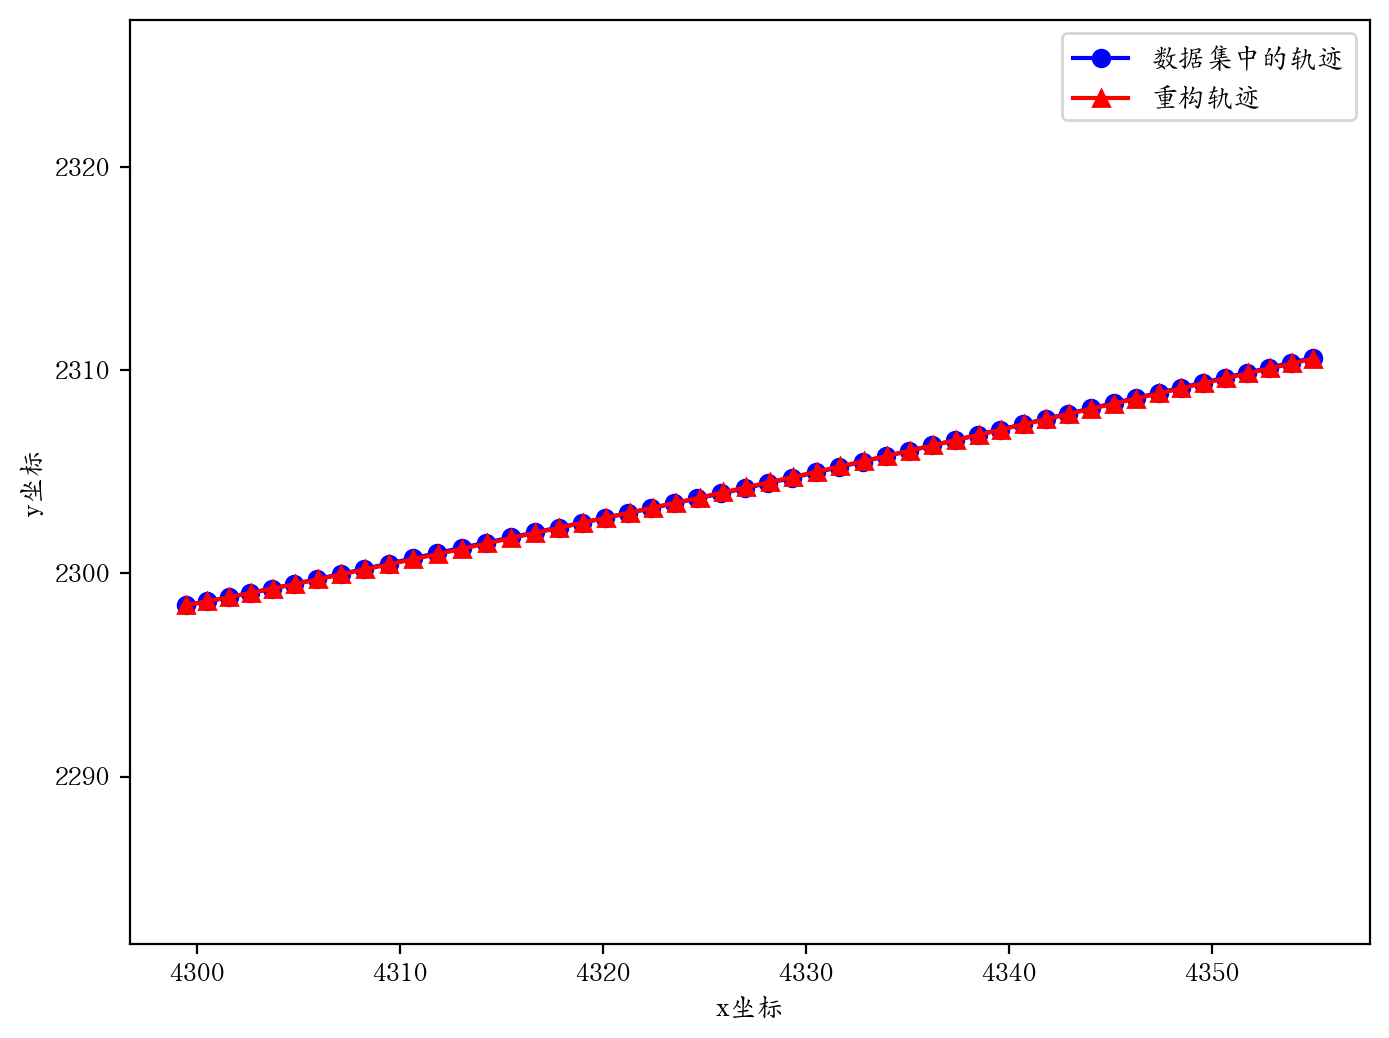

In [7]:
plt.figure(figsize=(8, 6),dpi=200)

plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']  # 指定字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
print(num)
# num = 29278
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='数据集中的轨迹')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-^', c='red', label='重构轨迹')
# plt.title('Reconstructed Trajectory')
plt.xlabel('x坐标')
plt.ylabel('y坐标')
plt.legend()
plt.axis('equal')
plt.show()

# 用原始轨迹直接差分计算
xo = val_label.cpu().numpy()[num, :,0]
yo = val_label.cpu().numpy()[num, :,1]

plt.show()

In [8]:

# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def AMDE_err(self,out,label):
        # 计算每个样本的误差
        error = ((out - label) ** 2).sum(dim=2).sqrt()
        # 提取最大值
        max_error, _ = error.max(dim=1)
        # 对最大值取平均
        amde = max_error.mean()
        return amde
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err1 = self.ADE_err(out,labels)
        loss_err1 = loss_err1.cpu().numpy()


        loss_err2 = self.AMDE_err(out,labels)
        loss_err2 = loss_err2.cpu().numpy()

        loss_err = [loss_err1,loss_err2]

        return loss_err

In [9]:
recon_tarj = Reconstruct_Traj()

err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('两点重构误差',err_two_point)

单点单向重构误差 [array(0.07721365, dtype=float32), array(0.20018877, dtype=float32)]
单点双向重构误差 [array(0.08597262, dtype=float32), array(0.17096148, dtype=float32)]
